# Loss Comparison
#### The purpose of this notebook is to evaluate the loss functions and metrics of four models (Gaussian 1, Gaussian 2, Lognormal 1, Lognormal 2).
#### You can find these models in the subdirectory GCNN_Models.
#### This notebook corresponds to the content in Chapter 7 and Appendix B of my Master's Thesis.
#### It also corresponds to the following figures: Figure 5.1, Figure 7.5, Figure 7.6, Figure 7.7, Figure 7.8, Figure 7.9, Figure 7.10, Figure 7.11, Figure B.4, Figure B.5.

# Part 1. Enviroment setting
#### Schwirigeste Teil von meiner Masterarbeit...

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
#import IPython
#print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

In [2]:
#%matplotlib notebook
import os
os.chdir("/home/r/R.Kanaki/Masterarbeit/מייַ_2023/prior_consideration")
import healpy as heal
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from healpy_networks_custom import HealpyGCNN
import healpy_layers_custom as hp_layer
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from standard_2D import Standardize_Min_Max_2D, Rescale_MSE_Min_Max_2D
import build_model
from Loss_mean import MyLoss
from livelossplot import PlotLossesKeras
from cov_by_hand import cov, chisq
import pandas as pd
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Part 2. Getting datas

#### Training data 1000 cosmology and each has 10 realization (lognormal and Gaussian)
#### Validation data 100 cosmology and each has 10 realization (lognormal and Gaussian)
#### Test data T17, maps from T17 N-body simulation 108 realization
#### Test data lognormal, maps from Flask 400 realization
#### Test data Gauss, maps from Flask 400 realization

In [4]:
training_data_lognormal_1      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_lognormal.npz')
training_data_lognormal_2      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_lognormal.npz')
training_data_Gauss_1          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_Gauss.npz')
training_data_Gauss_2          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_Gauss.npz')
testing_data_T17               = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/bin34/T17_downgraded_to_128.npz')
testing_data_lognormal_1       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_lognormal.npz')
testing_data_lognormal_2       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_lognormal.npz')
testing_data_Gauss_1           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_Gauss.npz')
testing_data_Gauss_2           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_Gauss.npz')
validation_data_Gauss          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_Gauss.npz')
validation_data_lognormal      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_lognormal.npz')

In [5]:
## For lognormal realization of flask maps, cosmology is same 
train_data_lognormal_1           = training_data_lognormal_1['lognormal_map']
train_data_lognormal_2           = training_data_lognormal_2['lognormal_map']
train_data_Gauss_1               = training_data_Gauss_1['lognormal_map']
train_data_Gauss_2               = training_data_Gauss_2['lognormal_map']
val_data_lognormal               = validation_data_lognormal['lognormal_map']
val_data_Gauss                   = validation_data_Gauss['lognormal_map']
test_data_T17                    = testing_data_T17['lognormal_map']
test_data_lognormal_1            = testing_data_lognormal_1['lognormal_map']
test_data_lognormal_2            = testing_data_lognormal_2['lognormal_map']
test_data_Gauss_1                = testing_data_Gauss_1['lognormal_map']
test_data_Gauss_2                = testing_data_Gauss_2['lognormal_map']

train_label_Omega_M_Gauss       = training_data_Gauss_1['Omega_M']
train_label_sigma_8_Gauss       = training_data_Gauss_1['sigma_8']
val_label_Omega_M_Gauss         = validation_data_Gauss['Omega_M']
val_label_sigma_8_Gauss         = validation_data_Gauss['sigma_8']
train_label_Omega_M_lognormal   = training_data_lognormal_1['Omega_M']
train_label_sigma_8_lognormal   = training_data_lognormal_1['sigma_8']
val_label_Omega_M_lognormal     = validation_data_lognormal['Omega_M']
val_label_sigma_8_lognormal     = validation_data_lognormal['sigma_8']
test_label_Omega_M_T17          = testing_data_T17['Omega_M']
test_label_sigma_8_T17          = testing_data_T17['sigma_8']
test_label_Omega_M_lognormal    = testing_data_lognormal_1['Omega_M']
test_label_sigma_8_lognormal    = testing_data_lognormal_1['sigma_8']
test_label_Omega_M_Gauss        = testing_data_Gauss_1['Omega_M']
test_label_sigma_8_Gauss        = testing_data_Gauss_1['sigma_8']

In [6]:
fiducial_Omega_M = test_label_Omega_M_T17[0]
fiducial_sigma_8 = test_label_sigma_8_T17[0]

In [7]:
train_labels_Gauss          = np.zeros((10000,2))
train_labels_lognormal      = np.zeros((10000,2))
validation_labels_Gauss     = np.zeros((2500,2))
validation_labels_lognormal = np.zeros((2500,2))
test_labels_T17             = np.zeros((108,2))
test_labels_Gauss           = np.zeros((300,2))
test_labels_lognormal       = np.zeros((300,2))
for i in range(len(train_label_Omega_M_Gauss)):
    train_labels_Gauss[i]          = np.array((train_label_Omega_M_Gauss[i], train_label_sigma_8_Gauss[i]))
    train_labels_lognormal[i]      = np.array((train_label_Omega_M_lognormal[i], train_label_sigma_8_lognormal[i]))
for i in range(len(val_label_sigma_8_Gauss)):
    validation_labels_Gauss[i]     = np.array((val_label_Omega_M_Gauss[i], val_label_sigma_8_Gauss[i]))
    validation_labels_lognormal[i] = np.array((val_label_Omega_M_lognormal[i], val_label_sigma_8_lognormal[i]))
for i in range(len(test_label_Omega_M_T17)):
    test_labels_T17[i]             =np.array((test_label_Omega_M_T17[i], test_label_sigma_8_T17[i]))
for i in range(len(test_label_Omega_M_lognormal)):
    test_labels_lognormal[i]       =np.array((test_label_Omega_M_lognormal[i], test_label_sigma_8_lognormal[i]))
    test_labels_Gauss[i]           =np.array((test_label_Omega_M_Gauss[i], test_label_sigma_8_Gauss[i]))

In [8]:
def data_preprocessing_train(maps):
    outputs = maps.astype(np.float32)[..., None]
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_test(maps):
    outputs = maps.astype(np.float32)[..., None]
    return outputs

def data_preprocessing_label_train(label):
    outputs = label.astype(np.float32)
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_label_test(label):
    outputs = label.astype(np.float32)
    return outputs

In [9]:
lognormal_train_1        = data_preprocessing_train(train_data_lognormal_1)
lognormal_train_2        = data_preprocessing_train(train_data_lognormal_2)
lognormal_val            = data_preprocessing_train(val_data_lognormal)
Gauss_train_1            = data_preprocessing_train(train_data_Gauss_1)
Gauss_train_2            = data_preprocessing_train(train_data_Gauss_2)
Gauss_val                = data_preprocessing_train(val_data_Gauss)
T17_test                 = data_preprocessing_test(test_data_T17)
lognormal_test_1         = data_preprocessing_test(test_data_lognormal_1)
lognormal_test_2         = data_preprocessing_test(test_data_lognormal_2)
Gauss_test_1             = data_preprocessing_test(test_data_Gauss_1)
Gauss_test_2             = data_preprocessing_test(test_data_Gauss_2)
labels_train_lognormal   = data_preprocessing_label_train(train_labels_lognormal)
labels_val_lognormal     = data_preprocessing_label_train(validation_labels_lognormal)
labels_train_Gauss       = data_preprocessing_label_train(train_labels_Gauss)
labels_val_Gauss         = data_preprocessing_label_train(validation_labels_Gauss)
labels_test_T17          = data_preprocessing_label_test(test_labels_T17)
labels_test_lognormal    = data_preprocessing_label_test(test_labels_lognormal)
labels_test_Gauss        = data_preprocessing_label_test(test_labels_Gauss)

In [10]:
%matplotlib inline

#### First we look at how LH Sampling is!

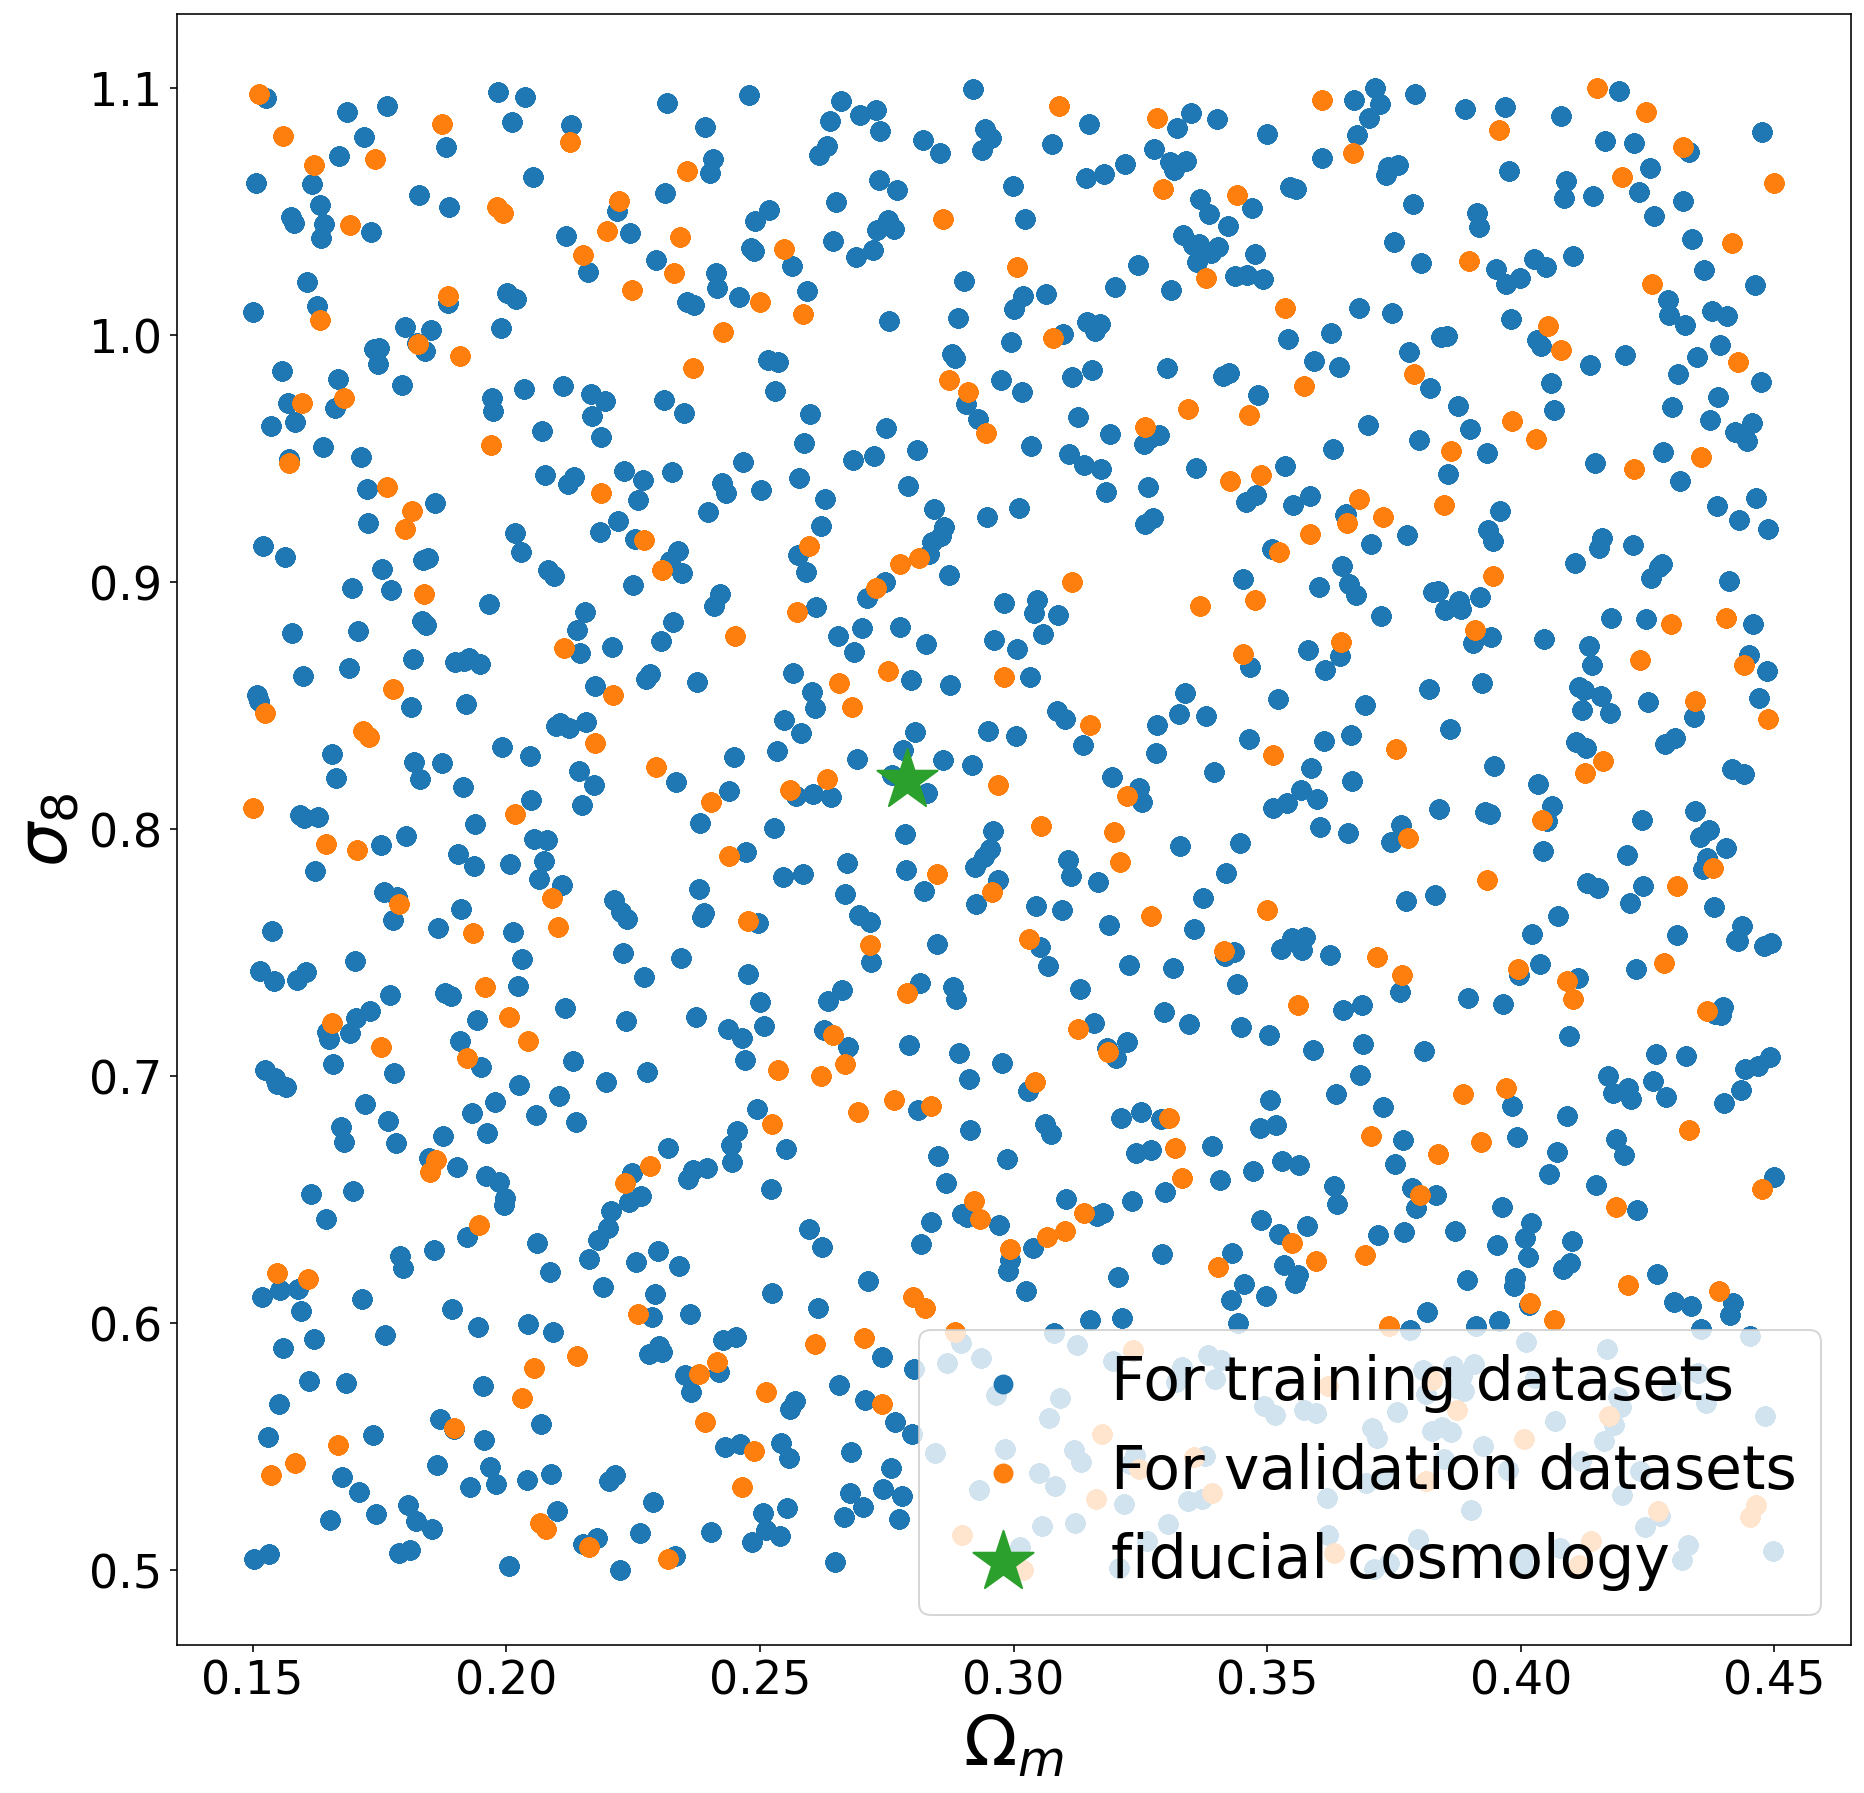

In [11]:
plt.figure(figsize=(15,15))
plt.scatter(train_label_Omega_M_lognormal, train_label_sigma_8_lognormal, s=80,label="For training datasets")
plt.scatter(val_label_Omega_M_lognormal, val_label_sigma_8_lognormal
            , s=80,label="For validation datasets")
plt.scatter(fiducial_Omega_M, fiducial_sigma_8,marker='*', s=1000, label="fiducial cosmology")
plt.xlabel("$\Omega_m$", fontsize=35)
plt.ylabel("$\sigma_8$", fontsize=35)
plt.legend(fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v5/Datasets_2D.png',bbox_inches='tight')
plt.show();

#### In reality, when dealing with just two parameters, either LH, random search, or grid search is effective.
#### For my previous task, I employed grid search for the escape room problem, and next time, I'll use random search.

# Part 3. Getting pretrained Network Lognormal

#### Actually Keras has problem with loading multiple models.
#### Detailed discussion see here! https://github.com/keras-team/keras/issues/8538
#### It is my way to solve this issue.

In [12]:
nside=128
npix = heal.nside2npix(nside)
indices = np.arange(npix)

In [13]:
def create_lognormal_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_lognormal_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model

In [14]:
loss_fc=MyLoss()
path_lognormal_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver5'
callbacks_lognormal = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_lognormal_2 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver7'
callbacks_lognormal_2 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver11'
callbacks_Gauss_1 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_2='/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver12'
callbacks_Gauss = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 3000,
    end_learning_rate=0.00001,
    power=1.0,
    cycle=False,
    name=None
)

In [15]:
checkpoint_path_lognormal_1 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_1/checkpoints/lognormal_weights.h5'
checkpoint_path_lognormal_2 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_2/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_1     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_1/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_2     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_2/checkpoints/lognormal_weights.h5'

#### Here I am calculating the predictions which I need later for evaluation!
#### This part of my code is quite heavy, if you want to run, please request many memories!

In [16]:
from keras import backend as K 
model_Gauss_1 = create_Gaussian_model_1(nside, indices)
model_Gauss_1.summary()
model_Gauss_1.load_weights(checkpoint_path_Gauss_1 , by_name=True)
model_Gauss_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_1            = model_Gauss_1.predict(T17_test)
prediction_lognormal_1_Gauss_1    = model_Gauss_1.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_1        = model_Gauss_1.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_1    = model_Gauss_1.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_1        = model_Gauss_1.predict(Gauss_test_2)
prediction_val_Gauss_1            = model_Gauss_1.predict(Gauss_val)
print(prediction_val_Gauss_1[1,0])
K.clear_session()
model_Gauss_2 = create_Gaussian_model_2(nside, indices)
model_Gauss_2.summary()
model_Gauss_2.load_weights(checkpoint_path_Gauss_2 , by_name=True)
model_Gauss_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_2            = model_Gauss_2.predict(T17_test)
prediction_lognormal_1_Gauss_2    = model_Gauss_2.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_2        = model_Gauss_2.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_2    = model_Gauss_2.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_2        = model_Gauss_2.predict(Gauss_test_2)
prediction_val_Gauss_2            = model_Gauss_2.predict(Gauss_val)
print(prediction_val_Gauss_2[1,0])
K.clear_session()
model_lognormal_1 = create_lognormal_model_1(nside, indices)
model_lognormal_1.summary()
model_lognormal_1.load_weights(checkpoint_path_lognormal_1, by_name=True)
model_lognormal_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_1            = model_lognormal_1.predict(T17_test)
prediction_lognormal_1_lognormal_1    = model_lognormal_1.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_1        = model_lognormal_1.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_1    = model_lognormal_1.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_1        = model_lognormal_1.predict(Gauss_test_2)
prediction_val_lognormal_1            = model_lognormal_1.predict(Gauss_val)
print(prediction_val_lognormal_1[1,0])
K.clear_session()
model_lognormal_2 = create_lognormal_model_2(nside, indices)
model_lognormal_2.summary()
model_lognormal_2.load_weights(checkpoint_path_lognormal_2, by_name=True)
model_lognormal_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_2            = model_lognormal_2.predict(T17_test)
prediction_lognormal_1_lognormal_2    = model_lognormal_2.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_2        = model_lognormal_2.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_2    = model_lognormal_2.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_2        = model_lognormal_2.predict(Gauss_test_2)
prediction_val_lognormal_2            = model_lognormal_2.predict(Gauss_val)
print(prediction_val_lognormal_2[1,0])
K.clear_session()

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 chebyshev (Chebyshev)       (None, 196608, 10)        50        
                                                                 
 healpy_pool (HealpyPool)    (None, 49152, 10)         0         
                                                                 
 chebyshev_1 (Chebyshev)     (None, 49152, 10)         500       
                                                                 
 healpy_pool_1 (HealpyPool)  (None, 12288, 10)         0         
                                                                 
 chebyshev_2 (Chebyshev)     (None, 12288, 10)         500       
                                                                 
 healpy

In [17]:
path_loss_Gauss_1     ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/Gauss_v11_loss_metrics_history.csv'
path_loss_Gauss_2     ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/Gauss_v12_loss_metrics_history.csv'
path_loss_lognormal_1 ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/lognormal_v5_loss_metrics_history.csv'
path_loss_lognormal_2 ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/lognormal_v7_loss_metrics_history.csv'
losses_Gauss_1     = pd.read_csv(path_loss_Gauss_1)
losses_Gauss_2     = pd.read_csv(path_loss_Gauss_2)
losses_lognormal_1 = pd.read_csv(path_loss_lognormal_1)
losses_lognormal_2 = pd.read_csv(path_loss_lognormal_2)

# Part 4. Loss Comparisson!

#### By using the Negative Log-Likelihood (NLL) loss function, you can obtain parameter estimations and their corresponding covariances.
#### This approach has been implemented in Fluri et al. 2019 (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.100.063514), Fluri et al. 2018 (https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.123518), and Perreault Levasseur et al. 2017 (https://doi.org/10.3847%2F2041-8213%2Faa9704).
#### I have followed Parth's version of the implementation, and you can review his upcoming paper for more details.

We have five outputs from the networks and two labels (supervised learning), which we can represent as:
$$
\hat{\theta}=[y_0,y_1,y_2,y_3,y_4]\text{ and }\theta_\mathrm{true}=[y_{0,\mathrm{true}}, y_{1, \mathrm{true}}]
$$
Now, let's consider the covariance matrix $\boldsymbol{\Sigma}$. Since it is a Hermitian positive definite matrix, we can perform Cholesky decomposition:
$$
\boldsymbol{\Sigma}=\mathbf{L}\mathbf{L}^T
$$
We parametrize this triangular matrix $\mathbf{L}$ as follows:
$$
\mathbf{L}=\begin{pmatrix}
e^{y_2}&0\\
y_4&e^{y_3}
\end{pmatrix}
$$
Next, we assume a Gaussian likelihood, and the negative log-likelihood $-\mathrm{ln}\mathcal{L}$ can be expressed as follows:
$$
-\mathrm{ln}\mathcal{L}=\frac{1}{2}(\mathrm{ln}|\mathrm{det}(\boldsymbol{\Sigma})|+(\hat{\theta}-\theta_\mathrm{true})^T\boldsymbol{\Sigma}(\hat{\theta}-\theta_\mathrm{true}))
$$
To minimize this, we define the loss function as follows:
$$
Loss=\mathrm{ln}|\mathrm{det}(\boldsymbol{\Sigma})|+(\hat{\theta}-\theta_\mathrm{true})^T\boldsymbol{\Sigma}(\hat{\theta}-\theta_\mathrm{true})
$$
Now, let's compute this in terms of labels and machine learning outputs:
$$
Loss=2(y_2+y_3)+(y_0-y_{0,\mathrm{true}})^2 e^{-2y_2}+(y_1-y_{1,\mathrm{true}})^2e^{-2y_3}+(y_0-y_{0,\mathrm{true}})^2 {y^2}_4 e^{-2(y_2+y_3)}-2(y_1-y_{1,\mathrm{true}})(y_0-y_{0,\mathrm{true}})y_4e^{-2y_3+y_2}
$$

### (i)**loss**: loss function above

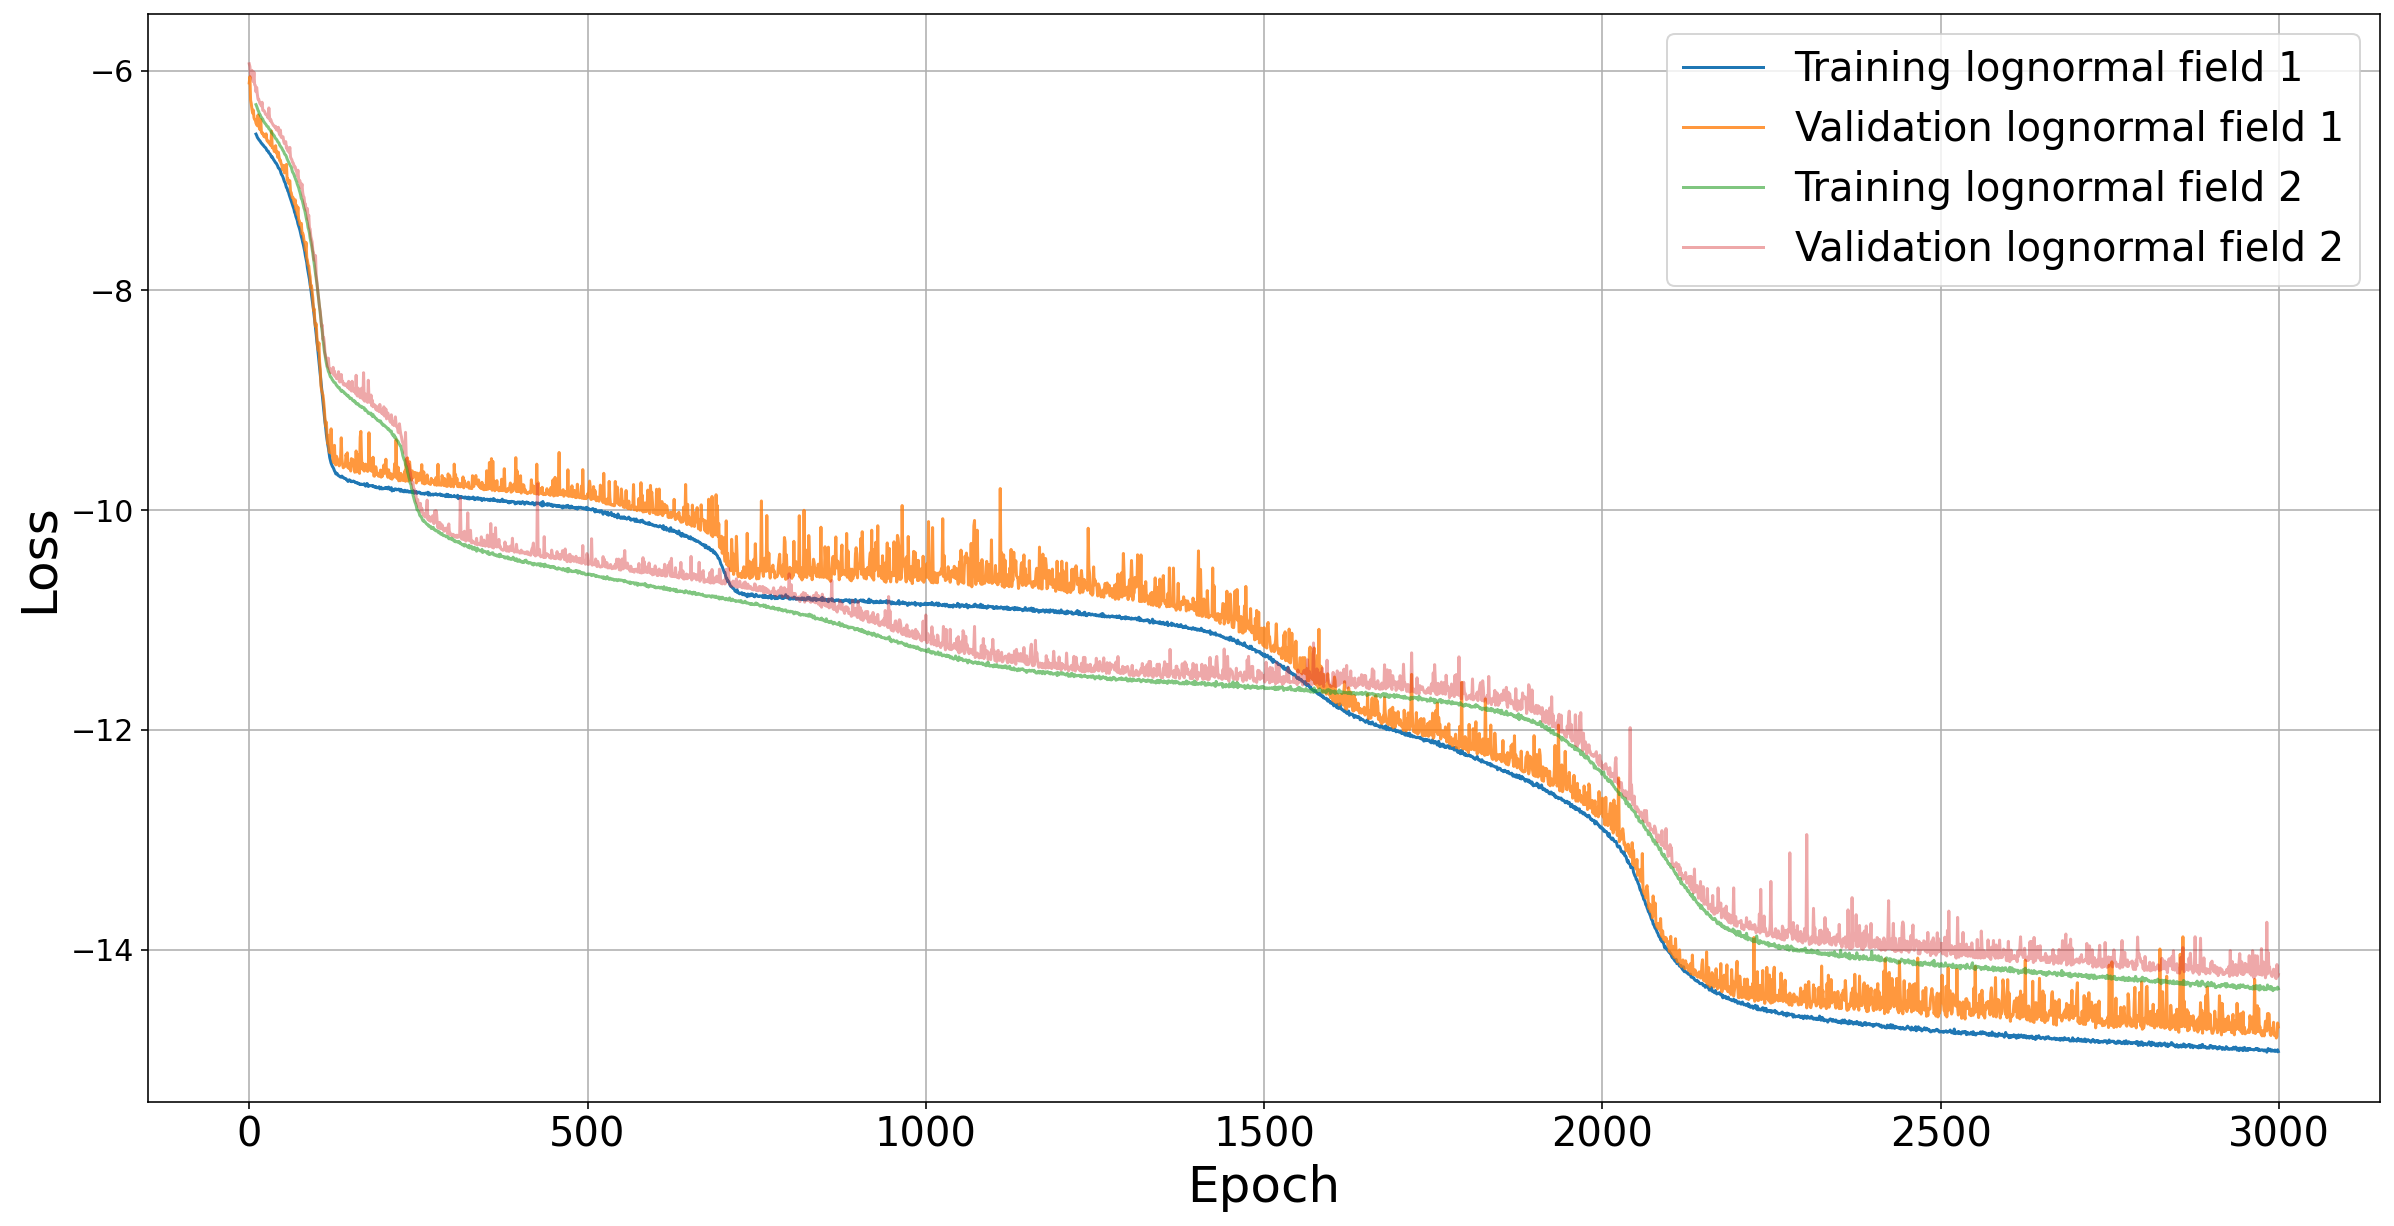

In [18]:
plt.figure(figsize=(20,10))
#plt.plot(losses_Gauss_1['loss'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_1['val_loss'][10:], label="Validation Gaussian field",alpha=0.9)
#plt.plot(losses_Gauss_2['loss'][10:], label="Training Gaussian field",alpha=0.8)
#plt.plot(losses_Gauss_2['val_loss'][10:], label="Validation Gaussian field",alpha=0.7)
plt.plot(losses_lognormal_1['loss'][10:], label="Training lognormal field 1")
plt.plot(losses_lognormal_1['val_loss'], label="Validation lognormal field 1",alpha=0.8)
plt.plot(losses_lognormal_2['loss'][10:], label="Training lognormal field 2",alpha=0.6)
plt.plot(losses_lognormal_2['val_loss'], label="Validation lognormal field 2",alpha=0.4)
plt.grid()
#plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/loss_lognormal.png',bbox_inches='tight')

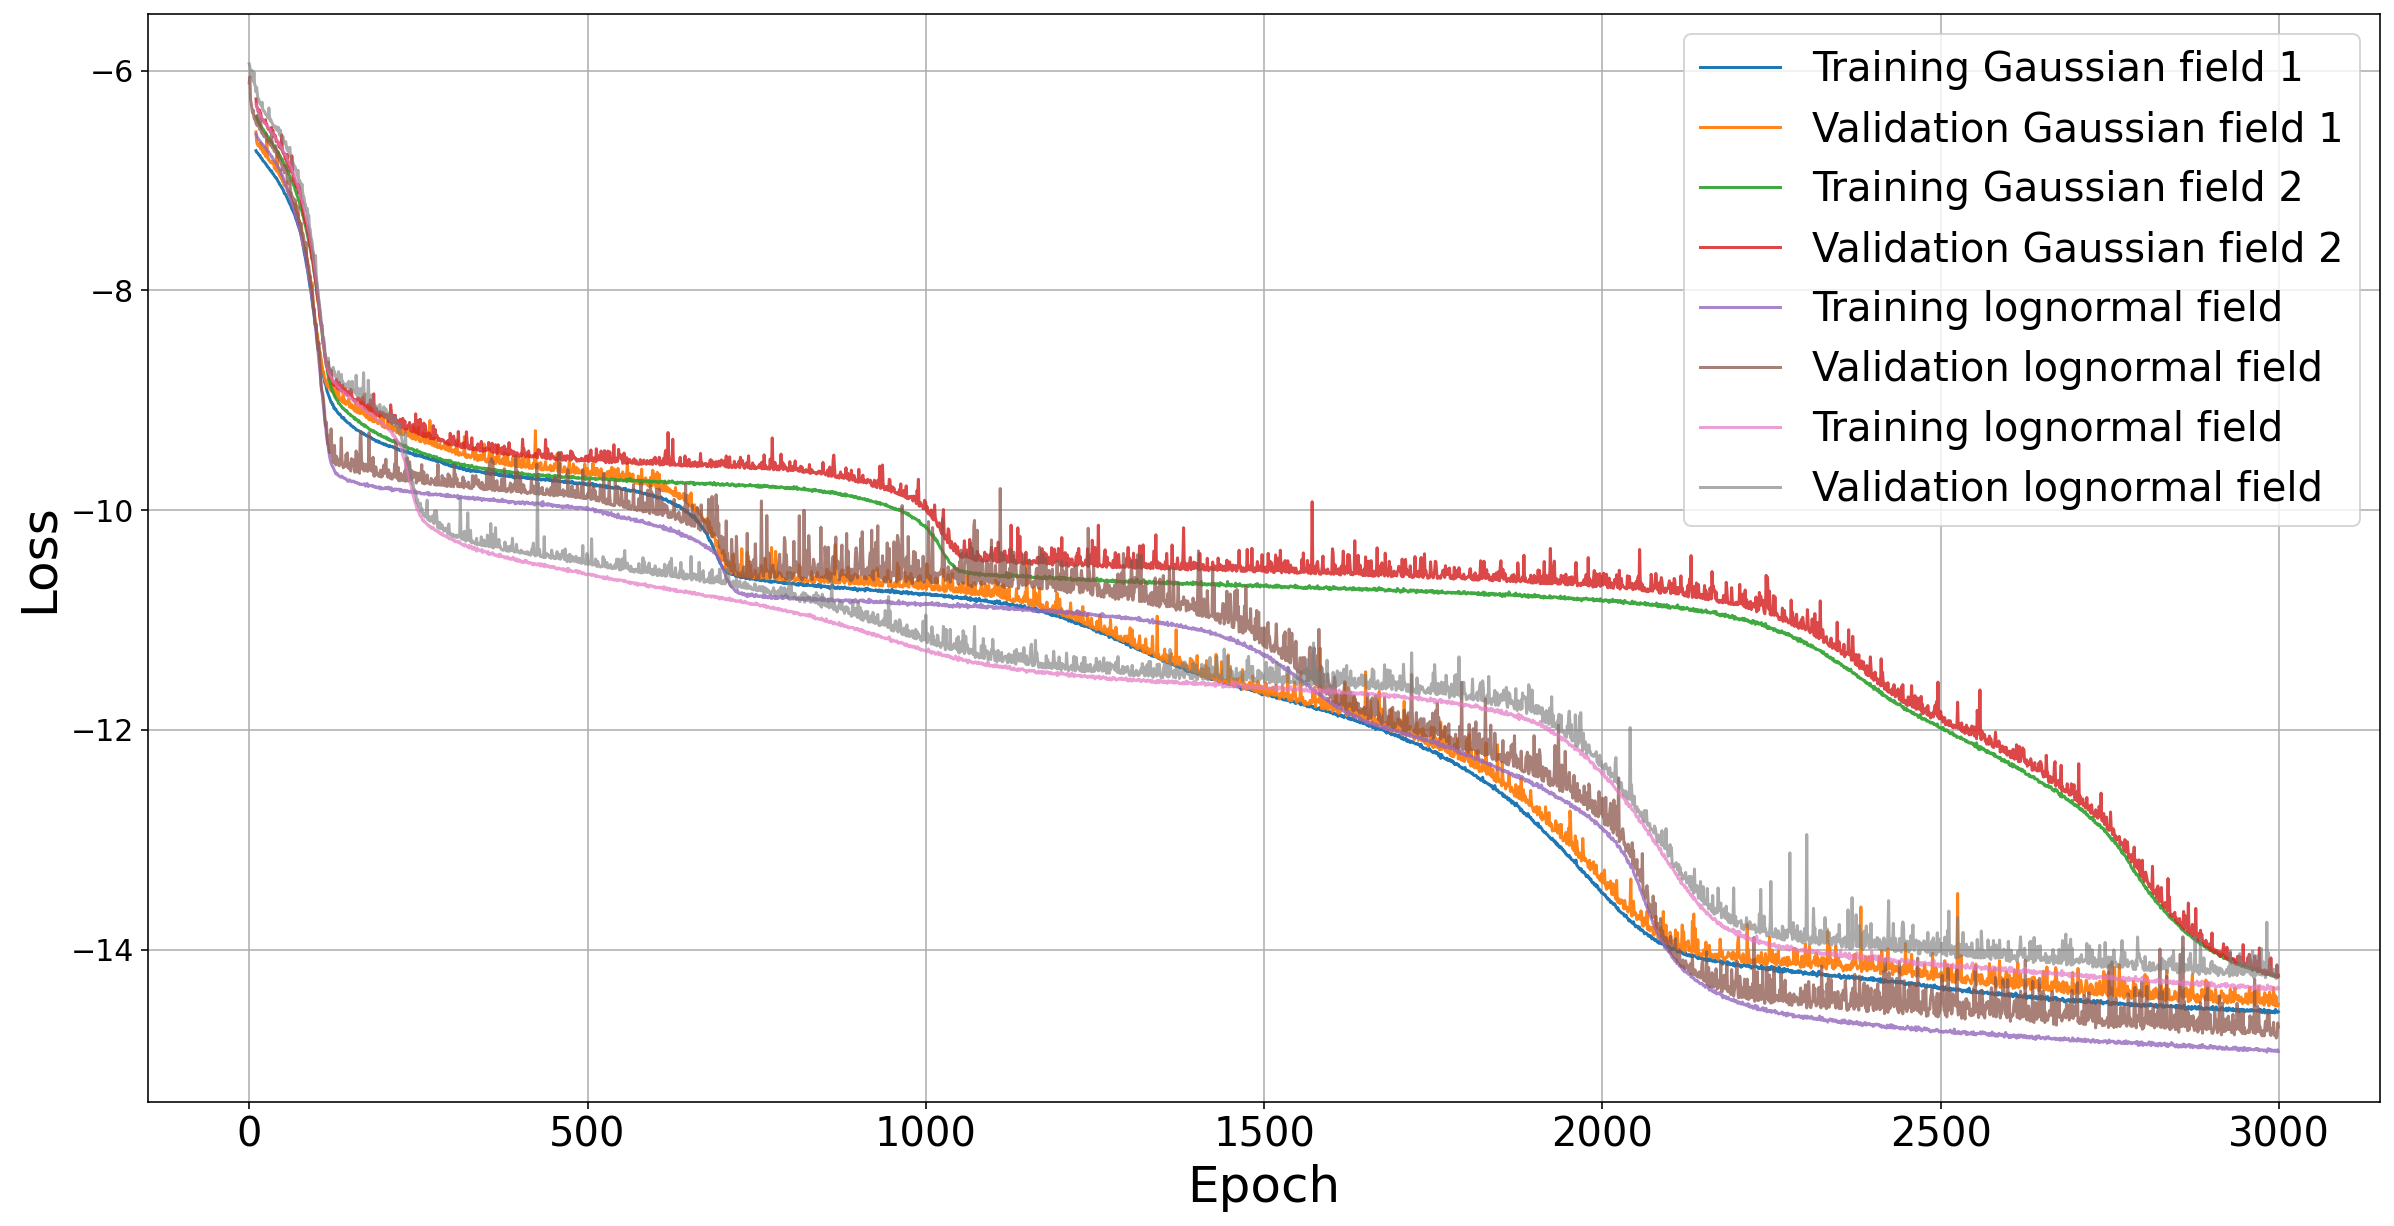

In [19]:
plt.figure(figsize=(20,10))
plt.plot(losses_Gauss_1['loss'][10:], label="Training Gaussian field 1")
plt.plot(losses_Gauss_1['val_loss'][10:], label="Validation Gaussian field 1",alpha=0.95)
plt.plot(losses_Gauss_2['loss'][10:], label="Training Gaussian field 2",alpha=0.9)
plt.plot(losses_Gauss_2['val_loss'][10:], label="Validation Gaussian field 2",alpha=0.85)
plt.plot(losses_lognormal_1['loss'][10:], label="Training lognormal field",alpha=0.8)
plt.plot(losses_lognormal_1['val_loss'], label="Validation lognormal field",alpha=0.75)
plt.plot(losses_lognormal_2['loss'][10:], label="Training lognormal field",alpha=0.7)
plt.plot(losses_lognormal_2['val_loss'], label="Validation lognormal field",alpha=0.65)
plt.grid()
#plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/loss_2.png',bbox_inches='tight')

#### Now we consider other metrics
### (i) **MSE(Mean Squared Error)** It is like 2D distance of labels to prediction

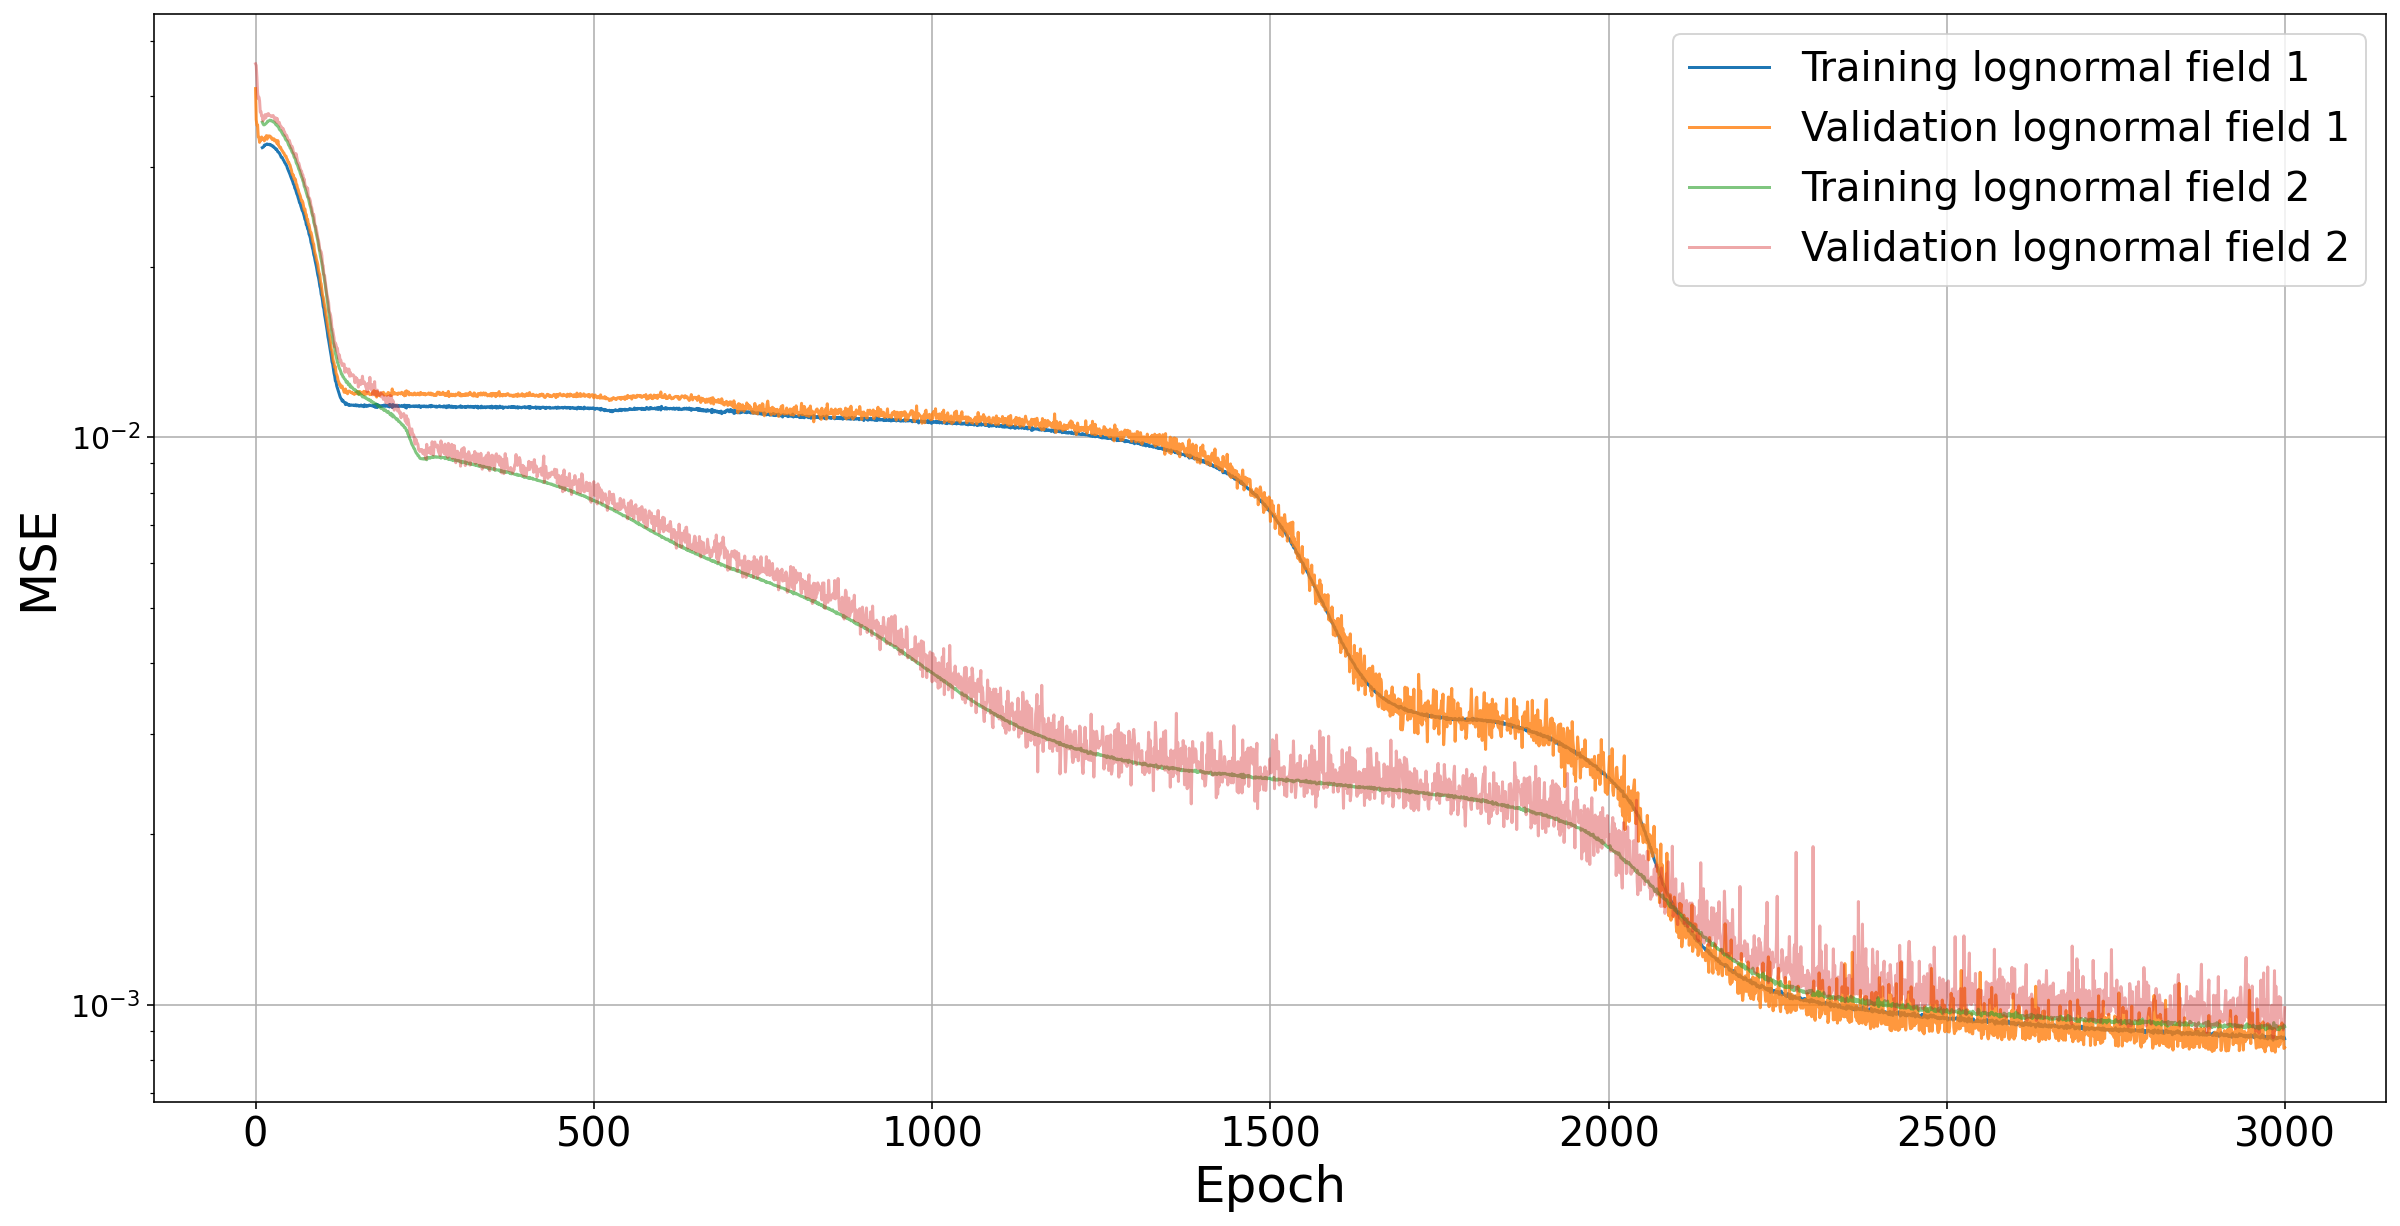

In [20]:
plt.figure(figsize=(20,10))
#plt.plot(losses_Gauss_1['MSE'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_1['val_MSE'][10:], label="Validation Gaussian field",alpha=0.8)
#plt.plot(losses_Gauss_2['MSE'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_2['val_MSE'][10:], label="Validation Gaussian field",alpha=0.8)
plt.plot(losses_lognormal_1['MSE'][10:], label="Training lognormal field 1")
plt.plot(losses_lognormal_1['val_MSE'], label="Validation lognormal field 1",alpha=0.8)
plt.plot(losses_lognormal_2['MSE'][10:], label="Training lognormal field 2",alpha=0.6)
plt.plot(losses_lognormal_2['val_MSE'], label="Validation lognormal field 2",alpha=0.4)
plt.grid()
plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/MSE_lognormal.png',bbox_inches='tight')

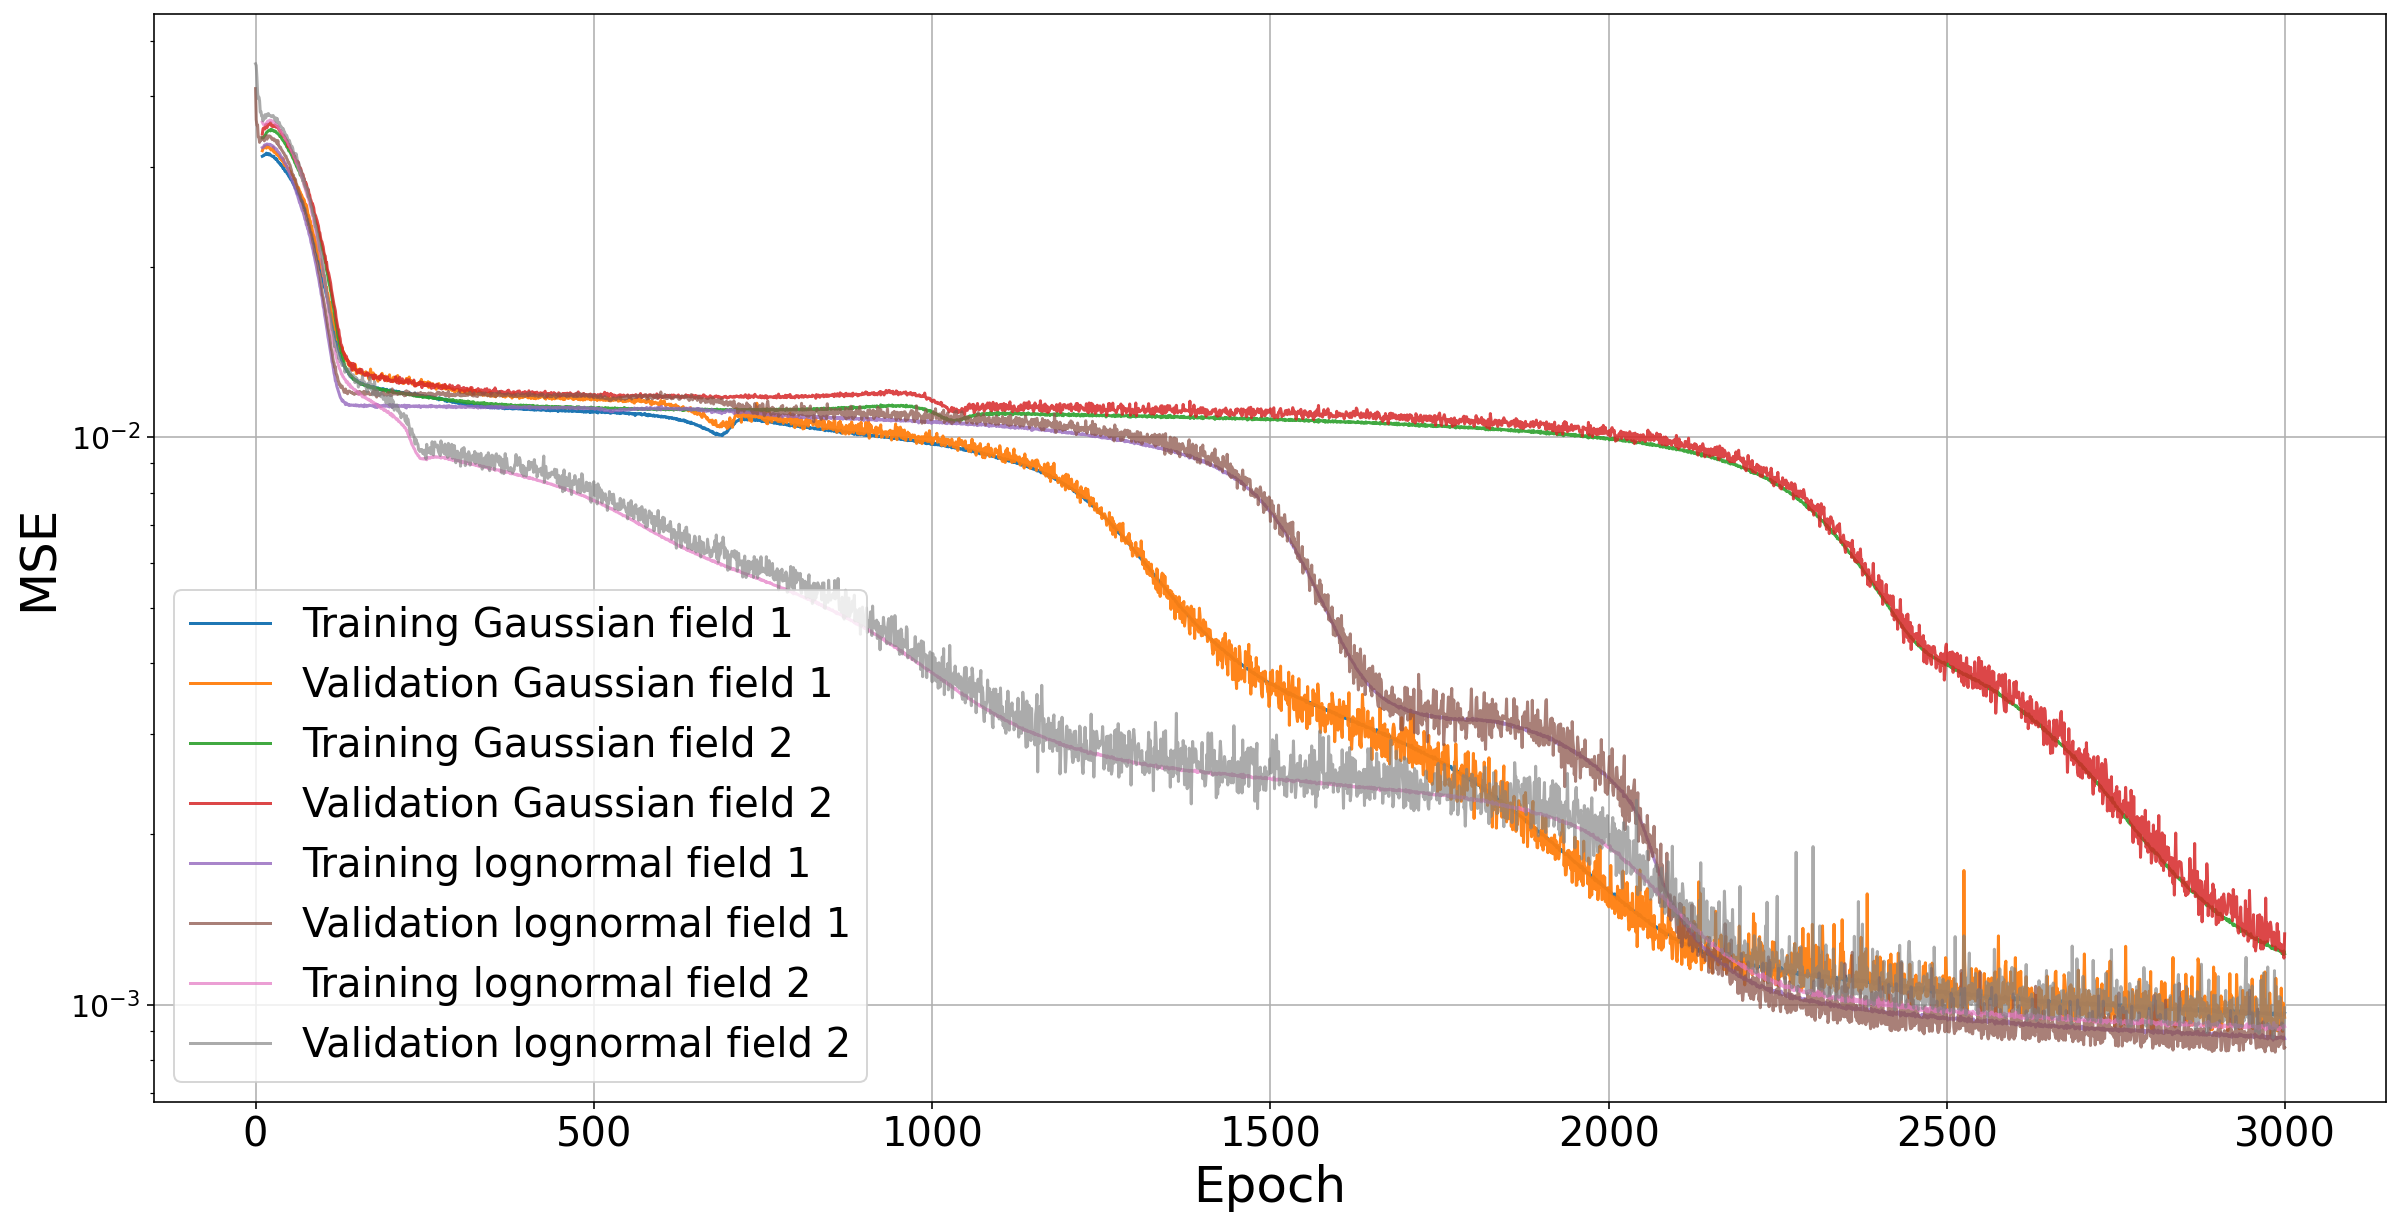

In [27]:
plt.figure(figsize=(20,10))
plt.plot(losses_Gauss_1['MSE'][10:], label="Training Gaussian field 1")
plt.plot(losses_Gauss_1['val_MSE'][10:], label="Validation Gaussian field 1",alpha=0.95)
plt.plot(losses_Gauss_2['MSE'][10:], label="Training Gaussian field 2",alpha=0.9)
plt.plot(losses_Gauss_2['val_MSE'][10:], label="Validation Gaussian field 2",alpha=0.85)
plt.plot(losses_lognormal_1['MSE'][10:], label="Training lognormal field 1",alpha=0.8)
plt.plot(losses_lognormal_1['val_MSE'], label="Validation lognormal field 1",alpha=0.75)
plt.plot(losses_lognormal_2['MSE'][10:], label="Training lognormal field 2",alpha=0.7)
plt.plot(losses_lognormal_2['val_MSE'], label="Validation lognormal field 2",alpha=0.65)
plt.grid()
plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/MSE_2.png',bbox_inches='tight')

### (ii) **$\boldsymbol{\chi}^2$** It is same as the term $(\hat{\theta}-\theta_\mathrm{true})^T\boldsymbol{\Sigma}(\hat{\theta}-\theta_\mathrm{true})$ in the loss. Since we have two parameters, if this metric converges to 2, then happy

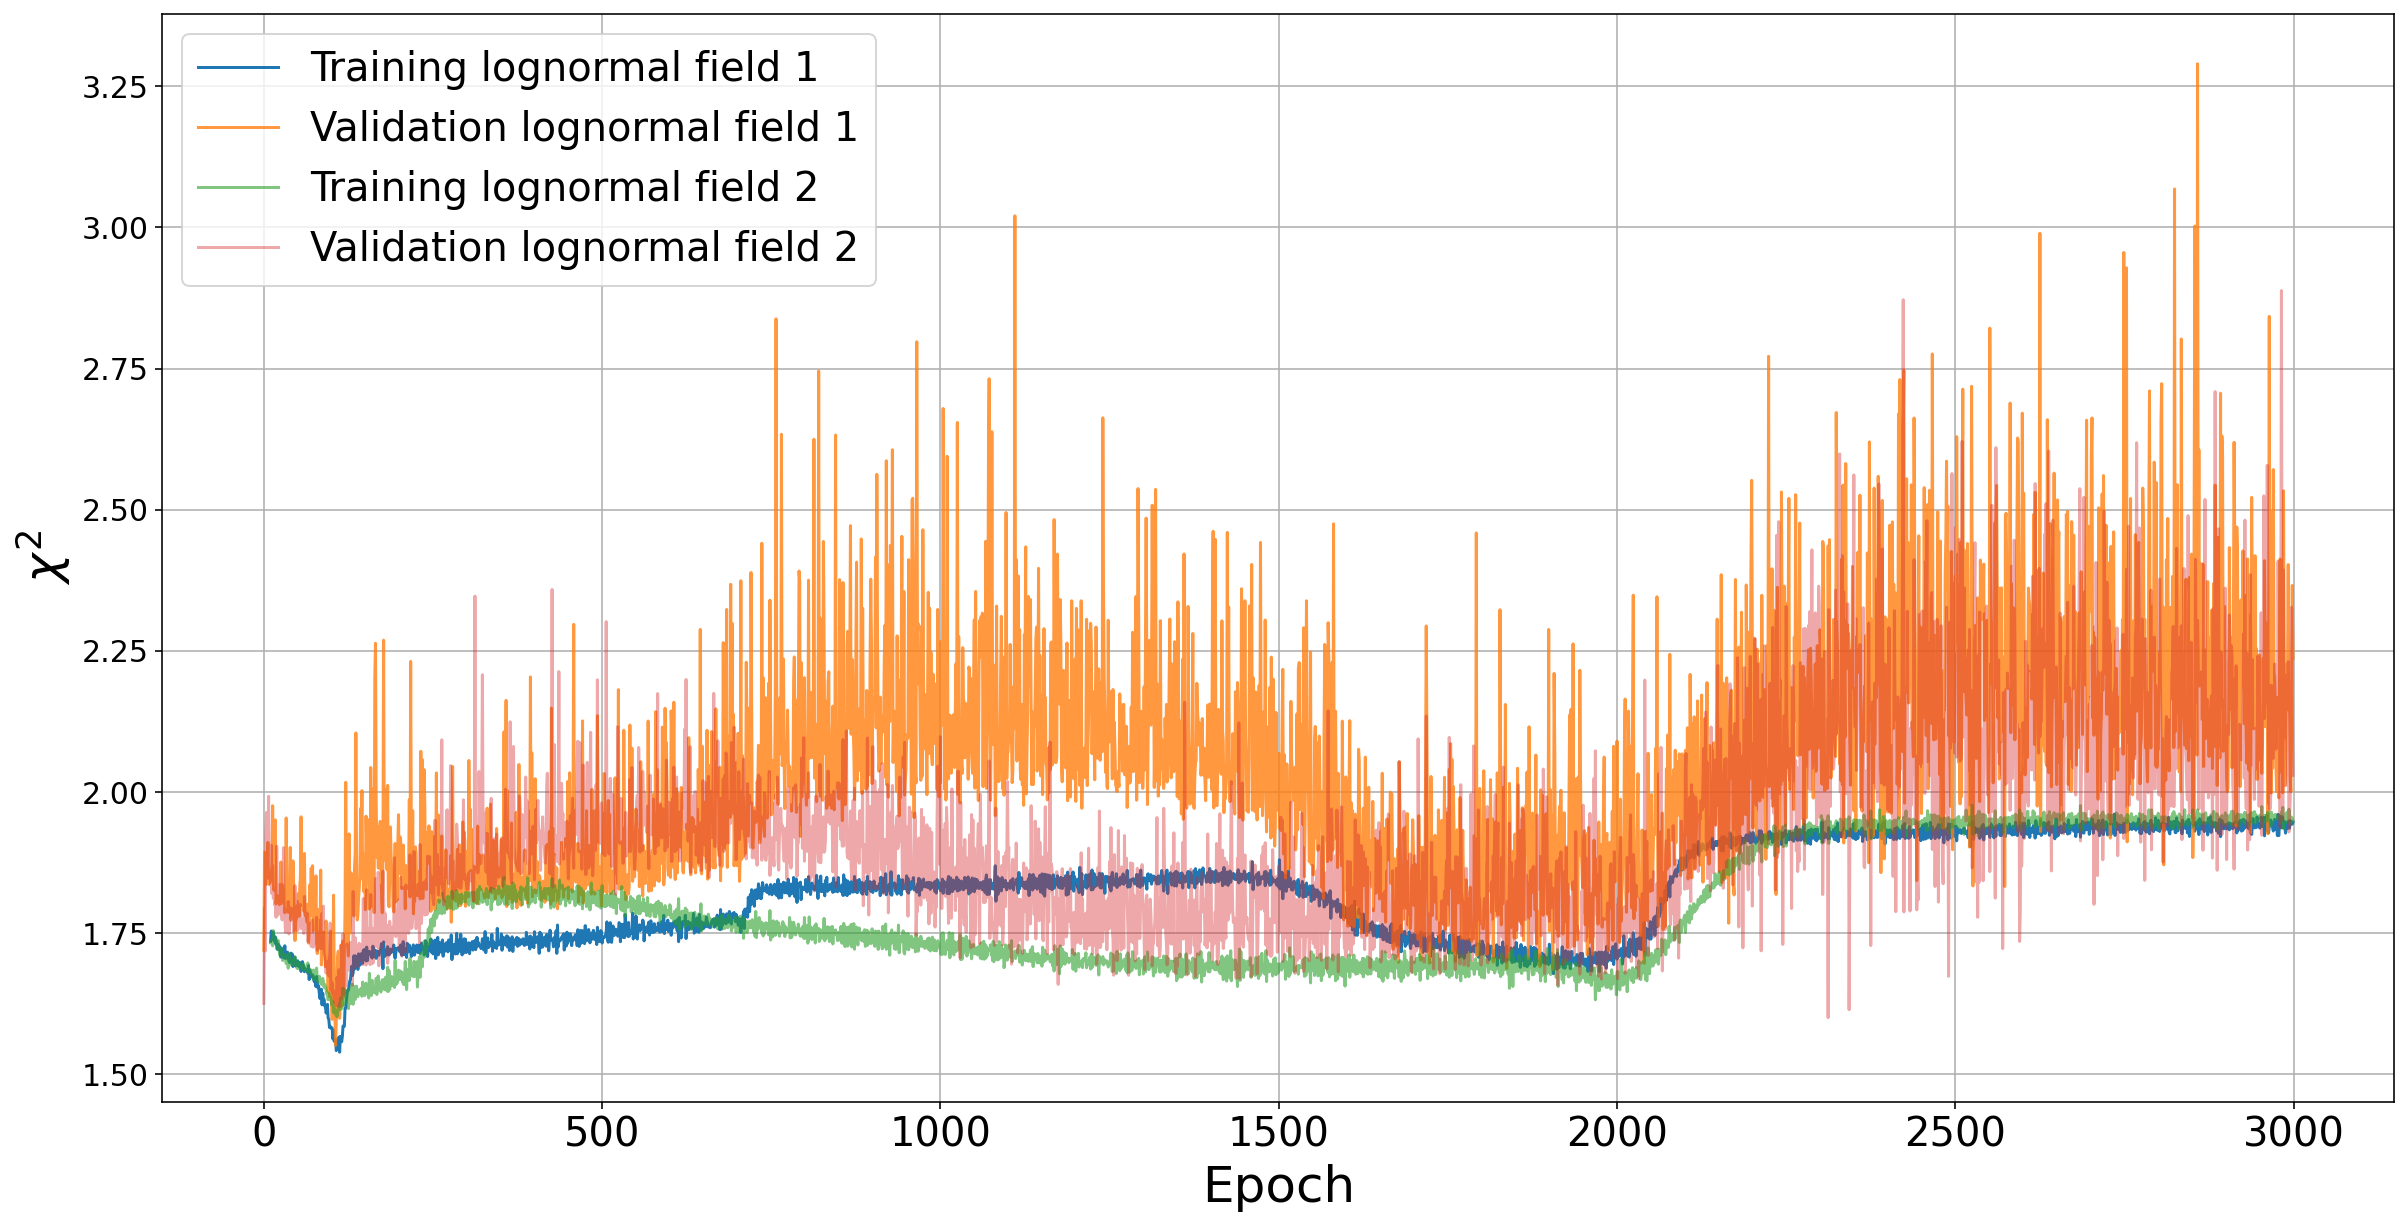

In [22]:
plt.figure(figsize=(20,10))
#plt.plot(losses_Gauss_1['chisq'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_1['val_chisq'][10:], label="Validation Gaussian field",alpha=0.8)
#plt.plot(losses_Gauss_2['chisq'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_2['val_chisq'][10:], label="Validation Gaussian field",alpha=0.8)
plt.plot(losses_lognormal_1['chisq'][10:], label="Training lognormal field 1")
plt.plot(losses_lognormal_1['val_chisq'], label="Validation lognormal field 1",alpha=0.8)
plt.plot(losses_lognormal_2['chisq'][10:], label="Training lognormal field 2",alpha=0.6)
plt.plot(losses_lognormal_2['val_chisq'], label="Validation lognormal field 2",alpha=0.4)
plt.grid()
#plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel(f"$\chi^2$",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/chisq_lognormal.png',bbox_inches='tight')

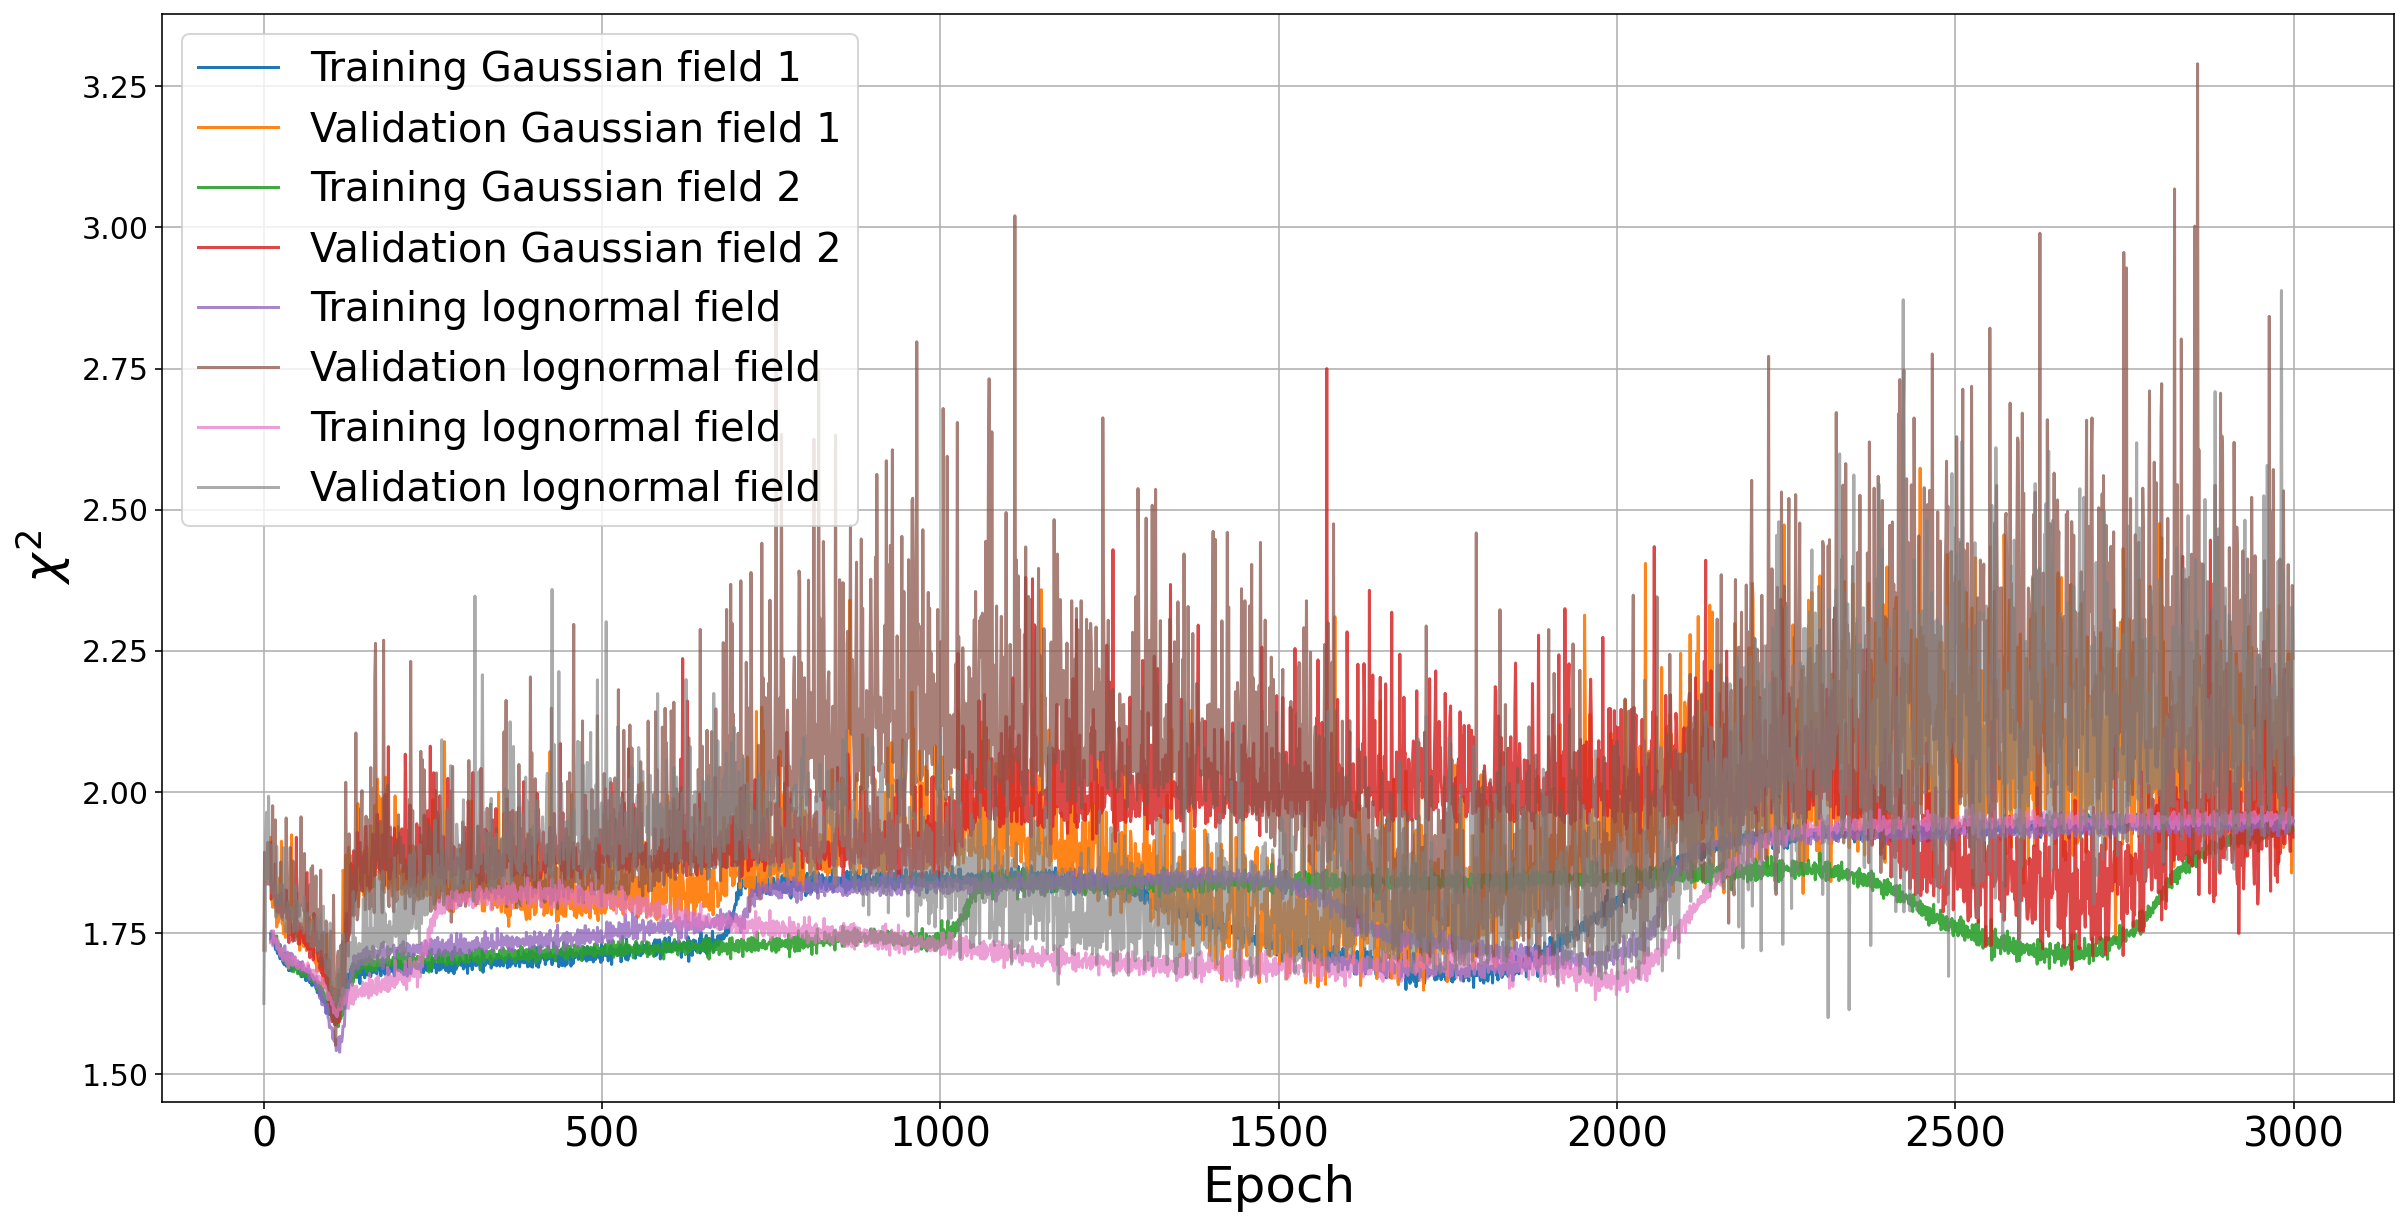

In [23]:
plt.figure(figsize=(20,10))
plt.plot(losses_Gauss_1['chisq'][10:], label="Training Gaussian field 1")
plt.plot(losses_Gauss_1['val_chisq'][10:], label="Validation Gaussian field 1",alpha=0.95)
plt.plot(losses_Gauss_2['chisq'][10:], label="Training Gaussian field 2",alpha=0.9)
plt.plot(losses_Gauss_2['val_chisq'][10:], label="Validation Gaussian field 2",alpha=0.85)
plt.plot(losses_lognormal_1['chisq'][10:], label="Training lognormal field",alpha=0.8)
plt.plot(losses_lognormal_1['val_chisq'], label="Validation lognormal field",alpha=0.75)
plt.plot(losses_lognormal_2['chisq'][10:], label="Training lognormal field",alpha=0.7)
plt.plot(losses_lognormal_2['val_chisq'], label="Validation lognormal field",alpha=0.65)
plt.grid()
#plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel(f"$\chi^2$",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/chisq_2.png',bbox_inches='tight')

### (iv)**$\mathrm{ln}|det(\boldsymbol{\Sigma})|$: Dominant part of loss, that's why loss can be negative. I understood this term as quality of convergence

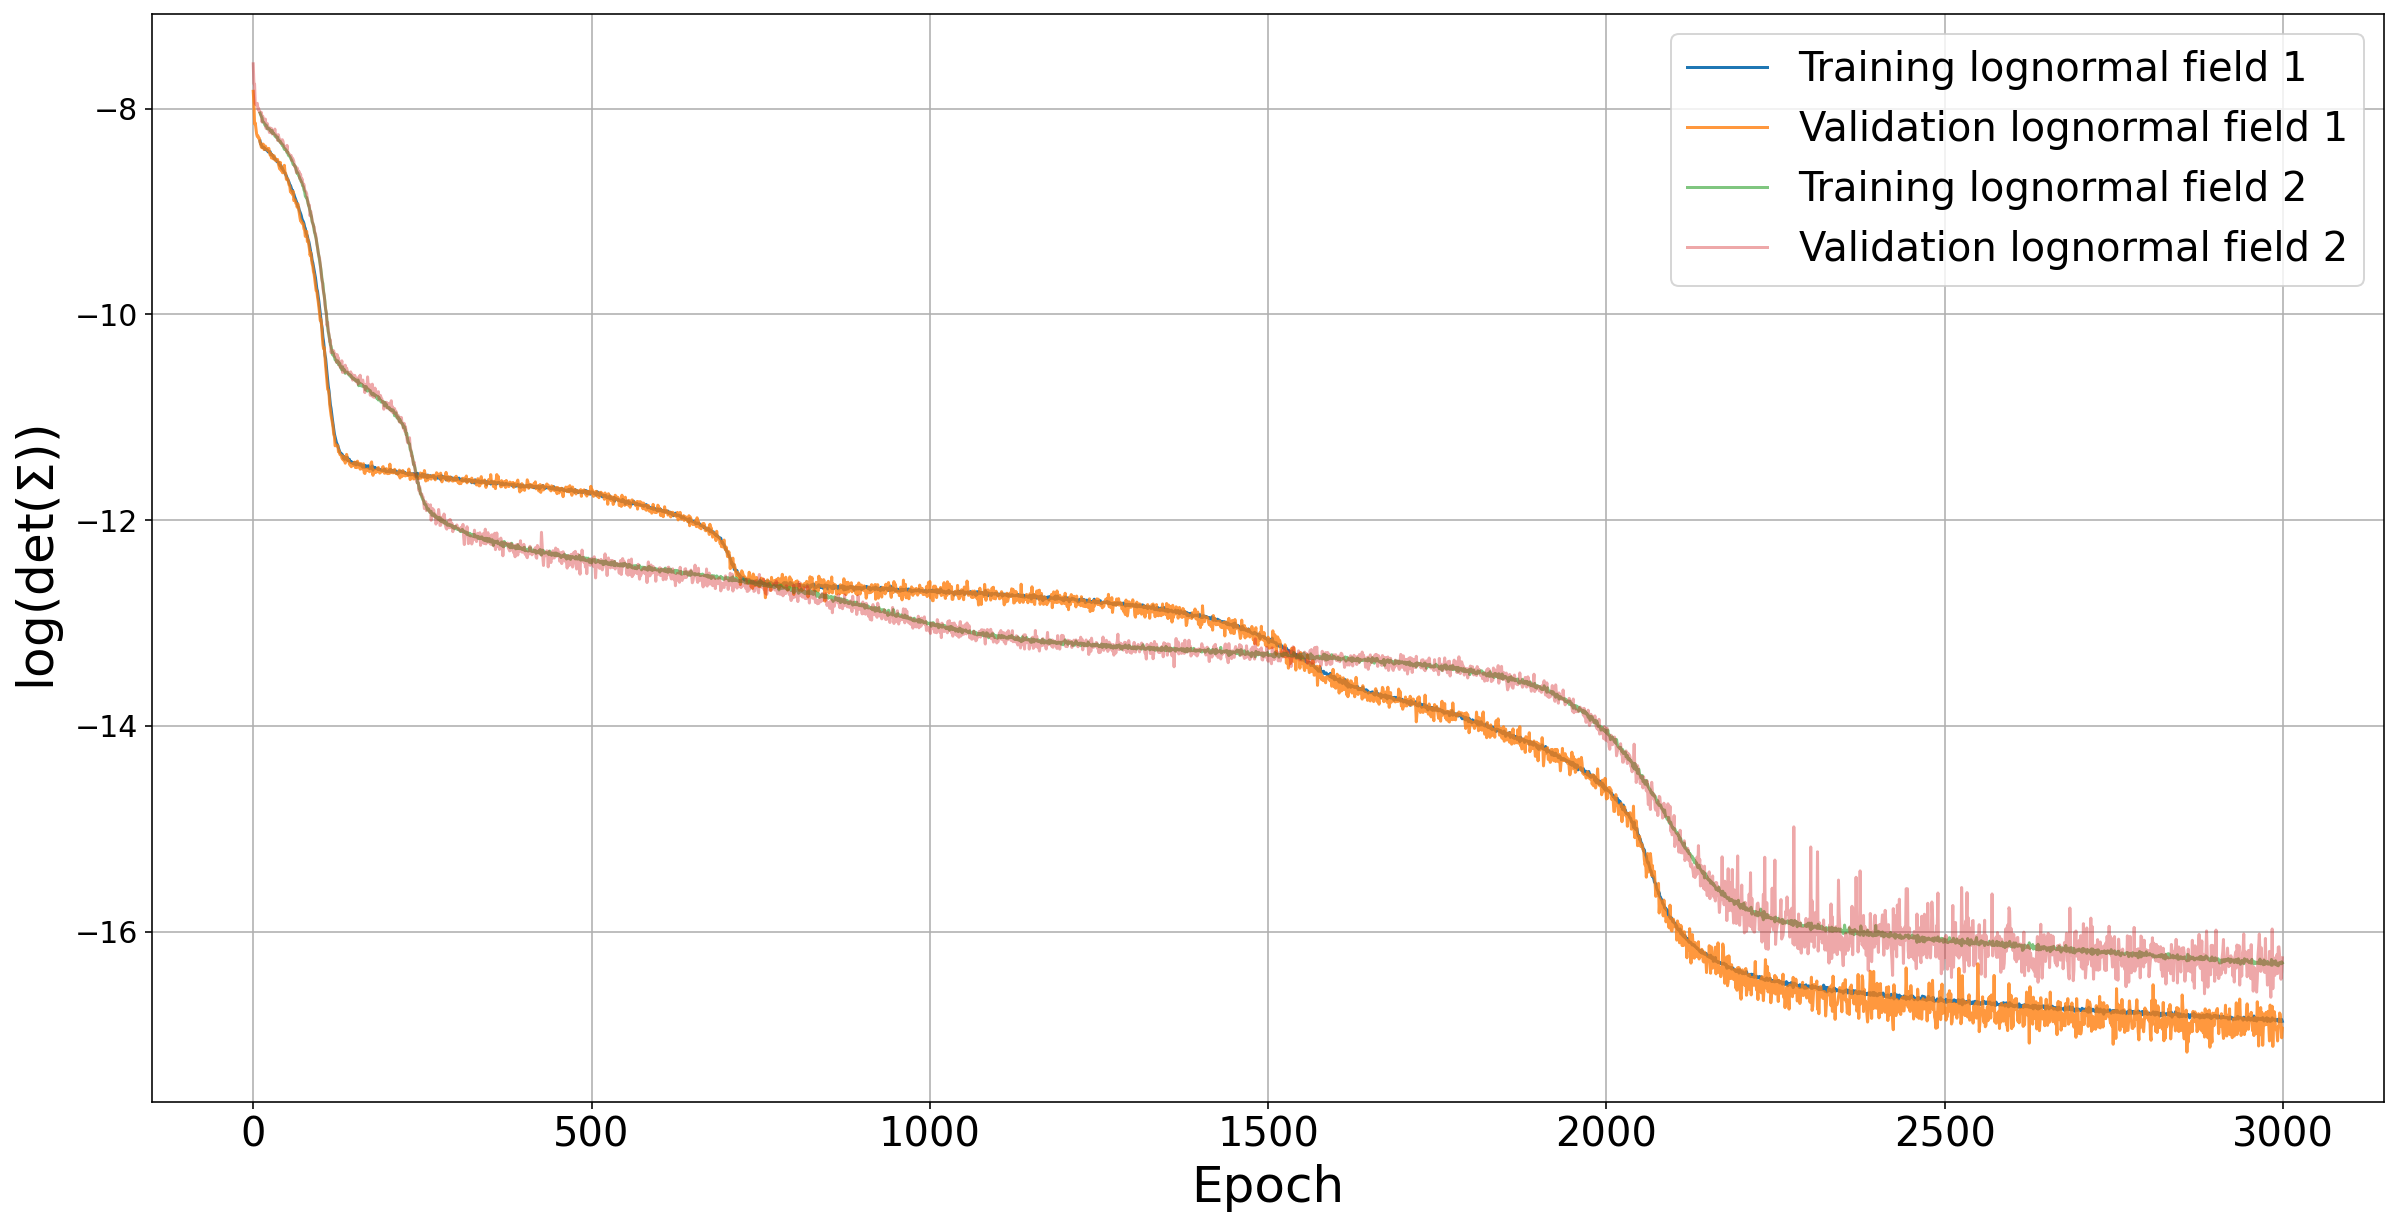

In [24]:
plt.figure(figsize=(20,10))
#plt.plot(losses_Gauss_1['log_det_Sigma'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_1['val_log_det_Sigma'][10:], label="Validation Gaussian field",alpha=0.8)
#plt.plot(losses_Gauss_2['log_det_Sigma'][10:], label="Training Gaussian field")
#plt.plot(losses_Gauss_2['val_log_det_Sigma'][10:], label="Validation Gaussian field",alpha=0.8)
plt.plot(losses_lognormal_1['log_det_Sigma'][10:], label="Training lognormal field 1")
plt.plot(losses_lognormal_1['val_log_det_Sigma'], label="Validation lognormal field 1",alpha=0.8)
plt.plot(losses_lognormal_2['log_det_Sigma'][10:], label="Training lognormal field 2",alpha=0.6)
plt.plot(losses_lognormal_2['val_log_det_Sigma'], label="Validation lognormal field 2",alpha=0.4)
plt.grid()
#plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel(f"log(det($\Sigma$))",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/log_det_Sigma_lognormal.png',bbox_inches='tight')

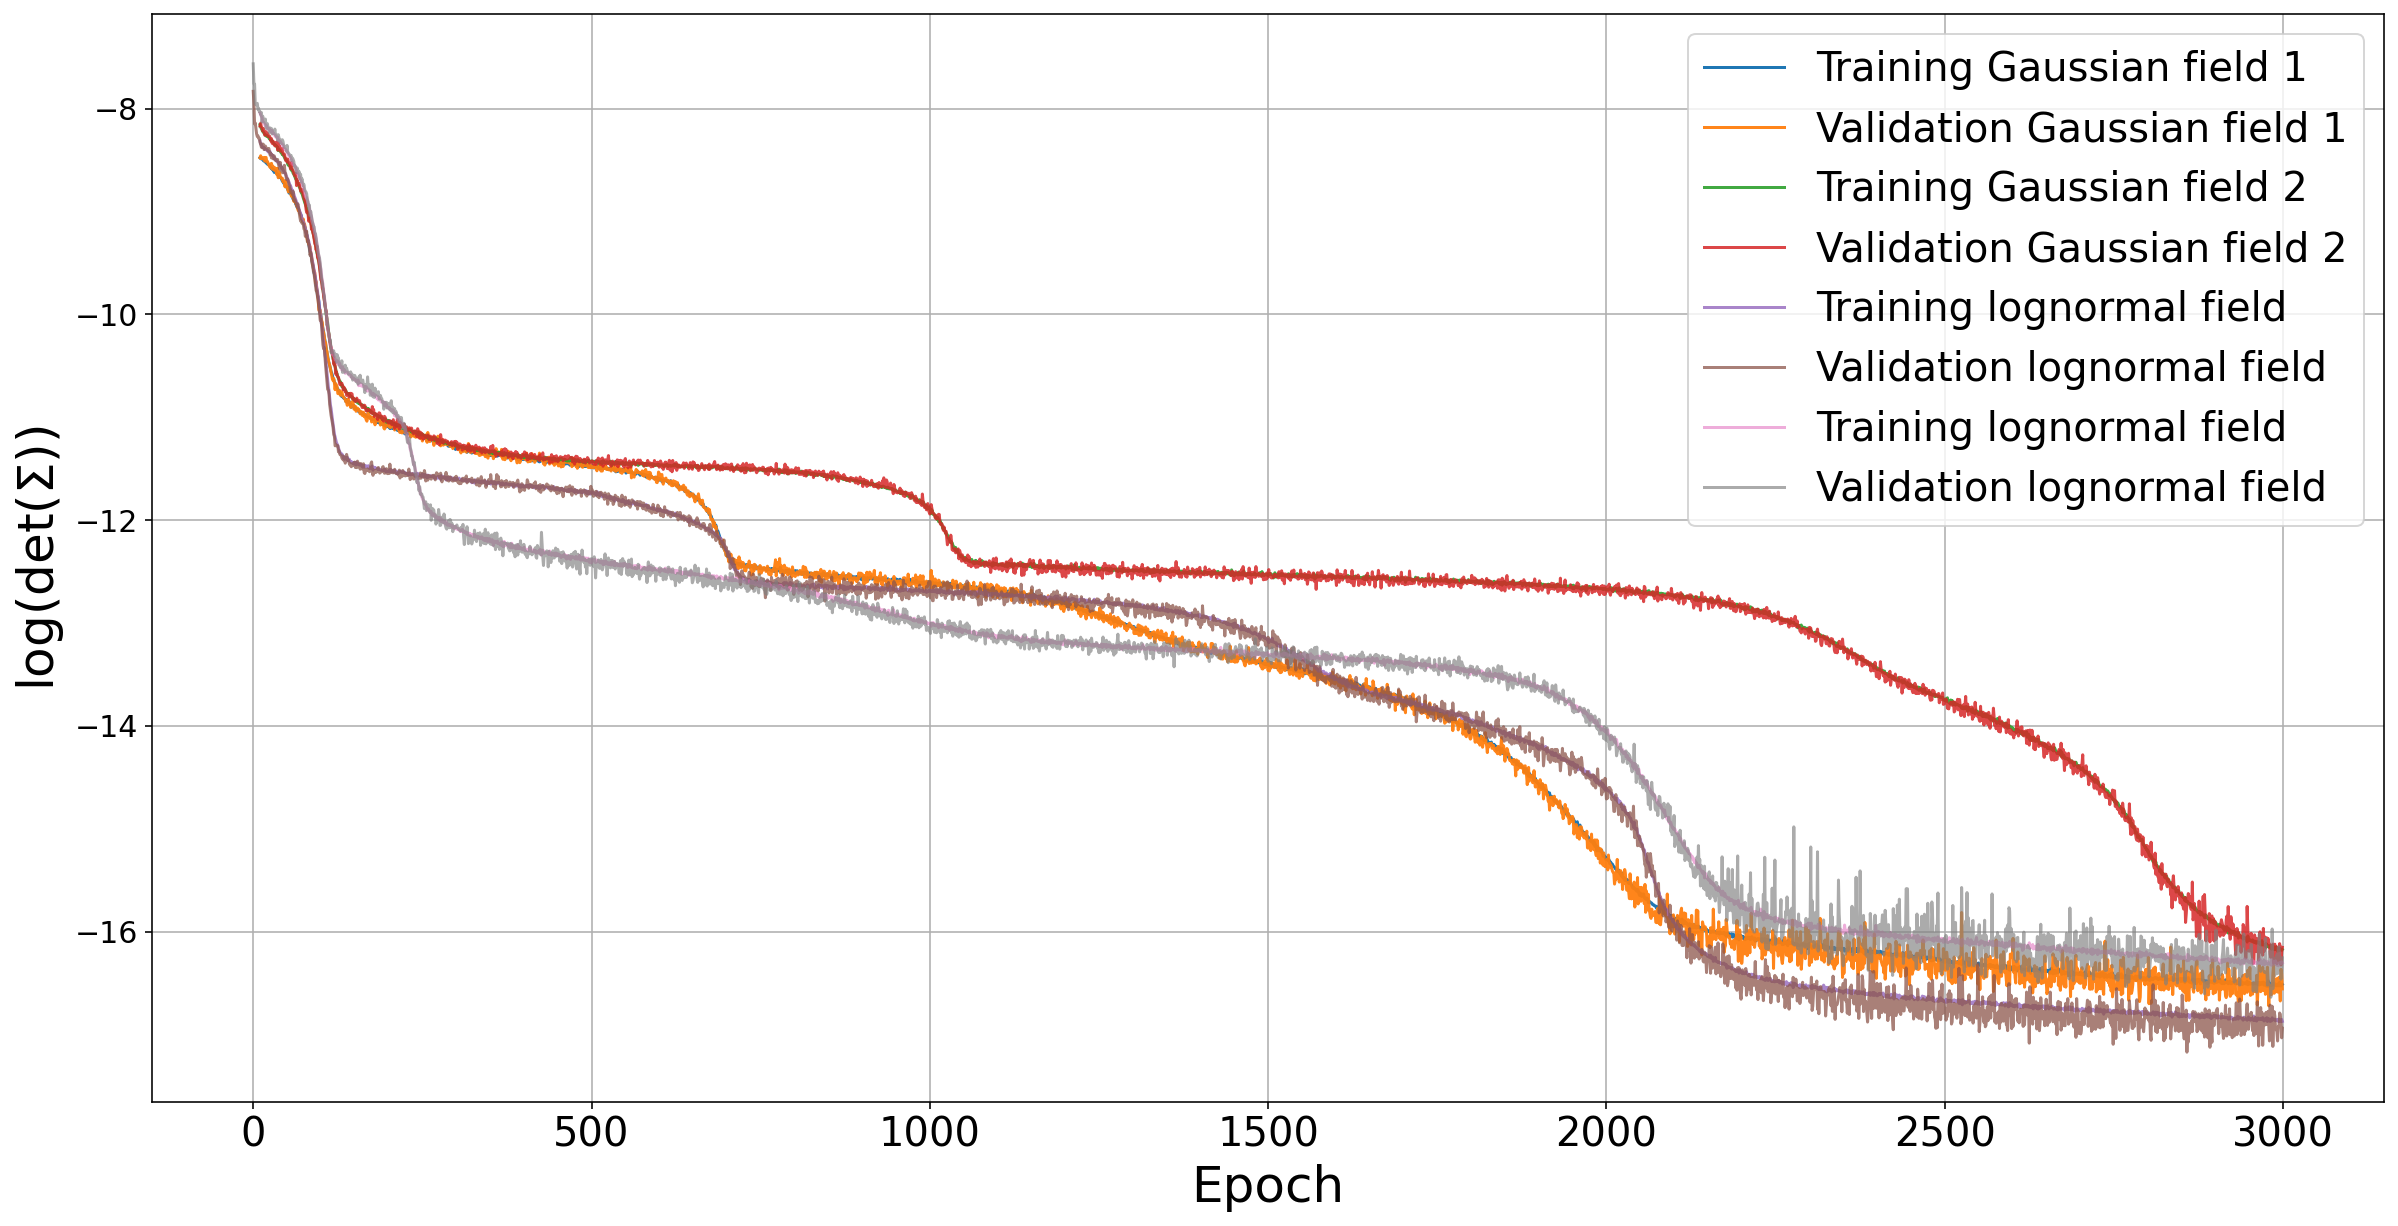

In [25]:
plt.figure(figsize=(20,10))
plt.plot(losses_Gauss_1['log_det_Sigma'][10:], label="Training Gaussian field 1")
plt.plot(losses_Gauss_1['val_log_det_Sigma'][10:], label="Validation Gaussian field 1",alpha=0.95)
plt.plot(losses_Gauss_2['log_det_Sigma'][10:], label="Training Gaussian field 2",alpha=0.9)
plt.plot(losses_Gauss_2['val_log_det_Sigma'][10:], label="Validation Gaussian field 2",alpha=0.85)
plt.plot(losses_lognormal_1['log_det_Sigma'][10:], label="Training lognormal field",alpha=0.8)
plt.plot(losses_lognormal_1['val_log_det_Sigma'], label="Validation lognormal field",alpha=0.75)
plt.plot(losses_lognormal_2['log_det_Sigma'][10:], label="Training lognormal field",alpha=0.6)
plt.plot(losses_lognormal_2['val_log_det_Sigma'], label="Validation lognormal field",alpha=0.65)
plt.grid()
#plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel(f"log(det($\Sigma$))",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/log_det_Sigma_2.png',bbox_inches='tight')

### Discussion
#### (1) Strange Heviside Step Function like Shape: I have no clear explanation for this phenomenon. I have three hypotheses to consider. First, the batch size may be too small. Second, my loss function is composed of two complex terms, and there might be an issue with the order of optimization. Third, the peculiar behavior could be an intrinsic nature of the learning rate decay. I've observed a similar pattern with this loss, as Kai has also experienced with same LR setting.
#### (2) Why the Significant Variance in Behavior? For instance, comparing Gaussian 1 to Gaussian 2, where I changed only the random seed of the simulation pipeline, we observed that the batch size might be too small, leading to unstable learning. But I don't have enough memories...
#### Conclusion: Forget GCNN and use flat sky! Then I don't need so many GPUs. or write proporsal to Leibnitz Rechenzentrum.

# Part 5. Validation test

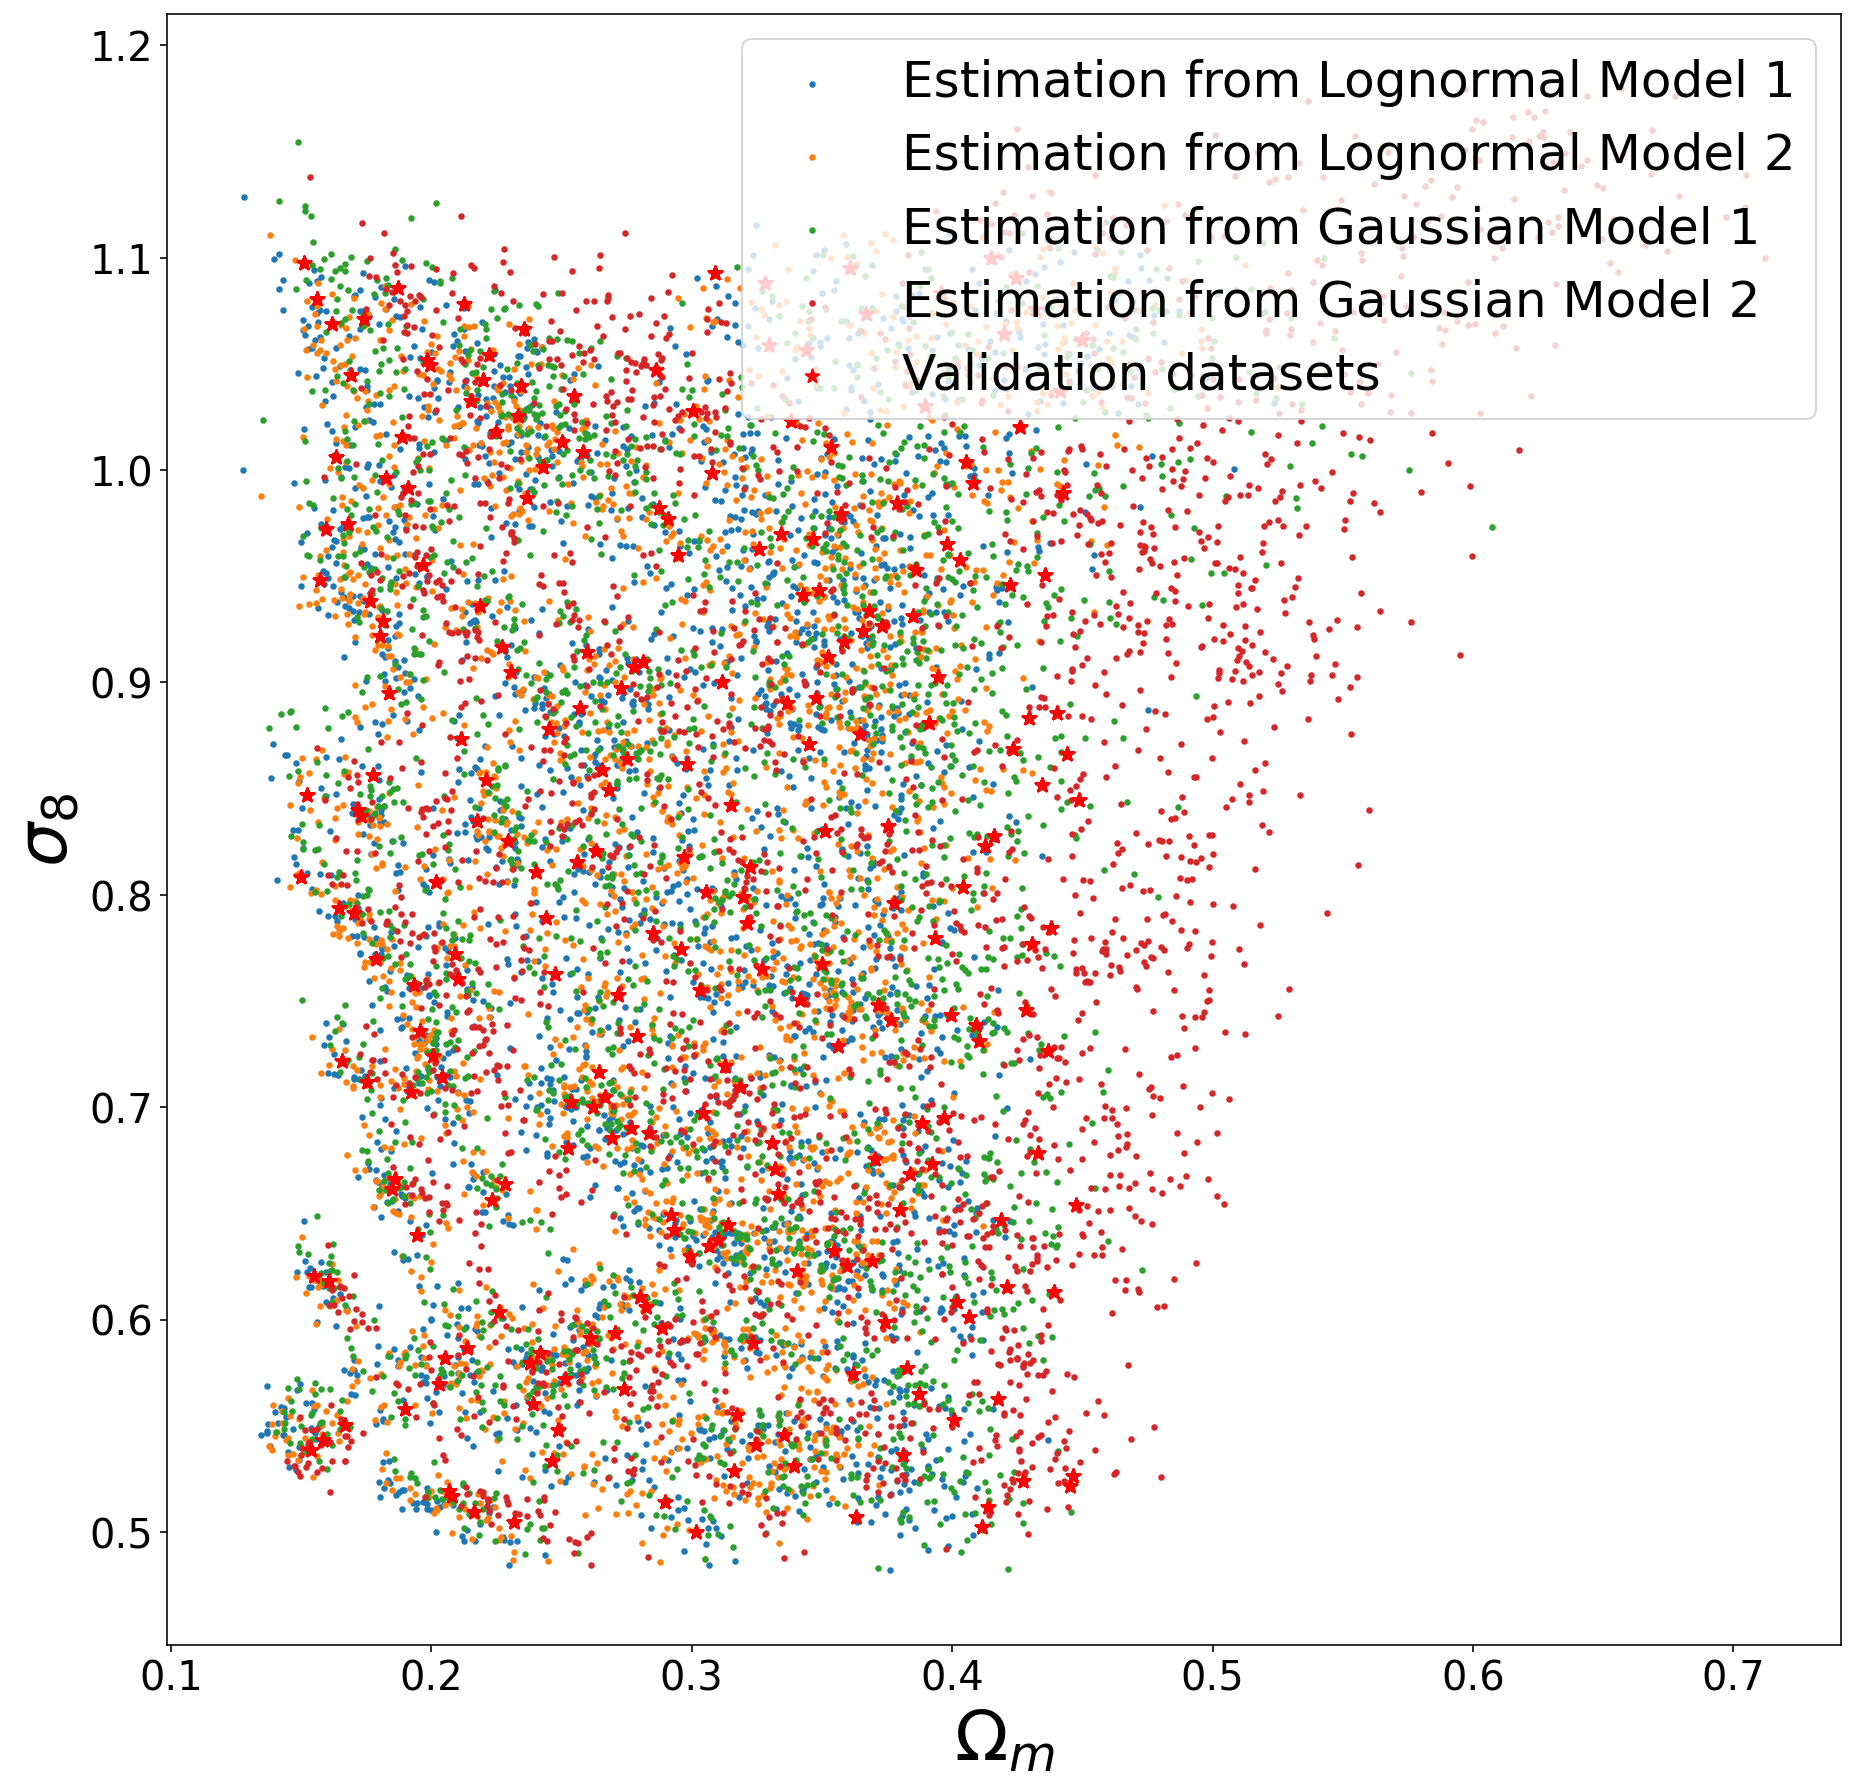

In [230]:
plt.figure(figsize=(15,15))
plt.scatter(prediction_val_Gauss_1[:,0],prediction_val_Gauss_1[:,1], label=f'Estimation from Lognormal Model 1',s=5)
plt.scatter(prediction_val_Gauss_2[:,0],prediction_val_Gauss_2[:,1], label=f'Estimation from Lognormal Model 2',s=5)
plt.scatter(prediction_val_lognormal_1[:,0],prediction_val_lognormal_1[:,1], label=f'Estimation from Gaussian Model 1',s=5)
plt.scatter(prediction_val_lognormal_2[:,0],prediction_val_lognormal_2[:,1], label=f'Estimation from Gaussian Model 2',s=5)
plt.scatter(labels_val_lognormal[:,0], labels_val_lognormal[:,1], marker='*', label='Validation datasets', s=50, color="red")
plt.legend(fontsize=25)
plt.ylabel(f"$\sigma_8$", fontsize=35)
plt.xlabel(f"$\Omega_m$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Validation_test_2D_2.jpg',bbox_inches='tight')
plt.show();

#### Looks bad in edge, no comment on that...

In [27]:
Omega_M_x                 =np.linspace(np.amax(labels_val_Gauss[:,0]), np.amin(labels_val_Gauss[:,0]),100)
sigma_8_x                 =np.linspace(np.amax(labels_val_Gauss[:,1]), np.amin(labels_val_Gauss[:,1]),100)
Omega_M_MSE_Gauss_1       = 1. / len(prediction_val_Gauss_1[:,0]) * np.sum((labels_val_Gauss[:,0]-prediction_val_Gauss_1[:,0])**2)
sigma_8_MSE_Gauss_1       = 1. / len(prediction_val_Gauss_1[:,1]) * np.sum((labels_val_Gauss[:,1]-prediction_val_Gauss_1[:,1])**2)
Omega_M_MSE_Gauss_2       = 1. / len(prediction_val_Gauss_2[:,0]) * np.sum((labels_val_Gauss[:,0]-prediction_val_Gauss_2[:,0])**2)
sigma_8_MSE_Gauss_2       = 1. / len(prediction_val_Gauss_2[:,1]) * np.sum((labels_val_Gauss[:,1]-prediction_val_Gauss_2[:,1])**2)
Omega_M_MSE_lognormal_1   = 1. / len(prediction_val_lognormal_1[:,0]) * np.sum((labels_val_lognormal[:,0]-prediction_val_lognormal_1[:,0])**2)
sigma_8_MSE_lognormal_1   = 1. / len(prediction_val_lognormal_1[:,1]) * np.sum((labels_val_lognormal[:,1]-prediction_val_lognormal_1[:,1])**2)
Omega_M_MSE_lognormal_2   = 1. / len(prediction_val_lognormal_2[:,0]) * np.sum((labels_val_lognormal[:,0]-prediction_val_lognormal_2[:,0])**2)
sigma_8_MSE_lognormal_2   = 1. / len(prediction_val_lognormal_2[:,1]) * np.sum((labels_val_lognormal[:,1]-prediction_val_lognormal_2[:,1])**2)

In [28]:
step_size = 5

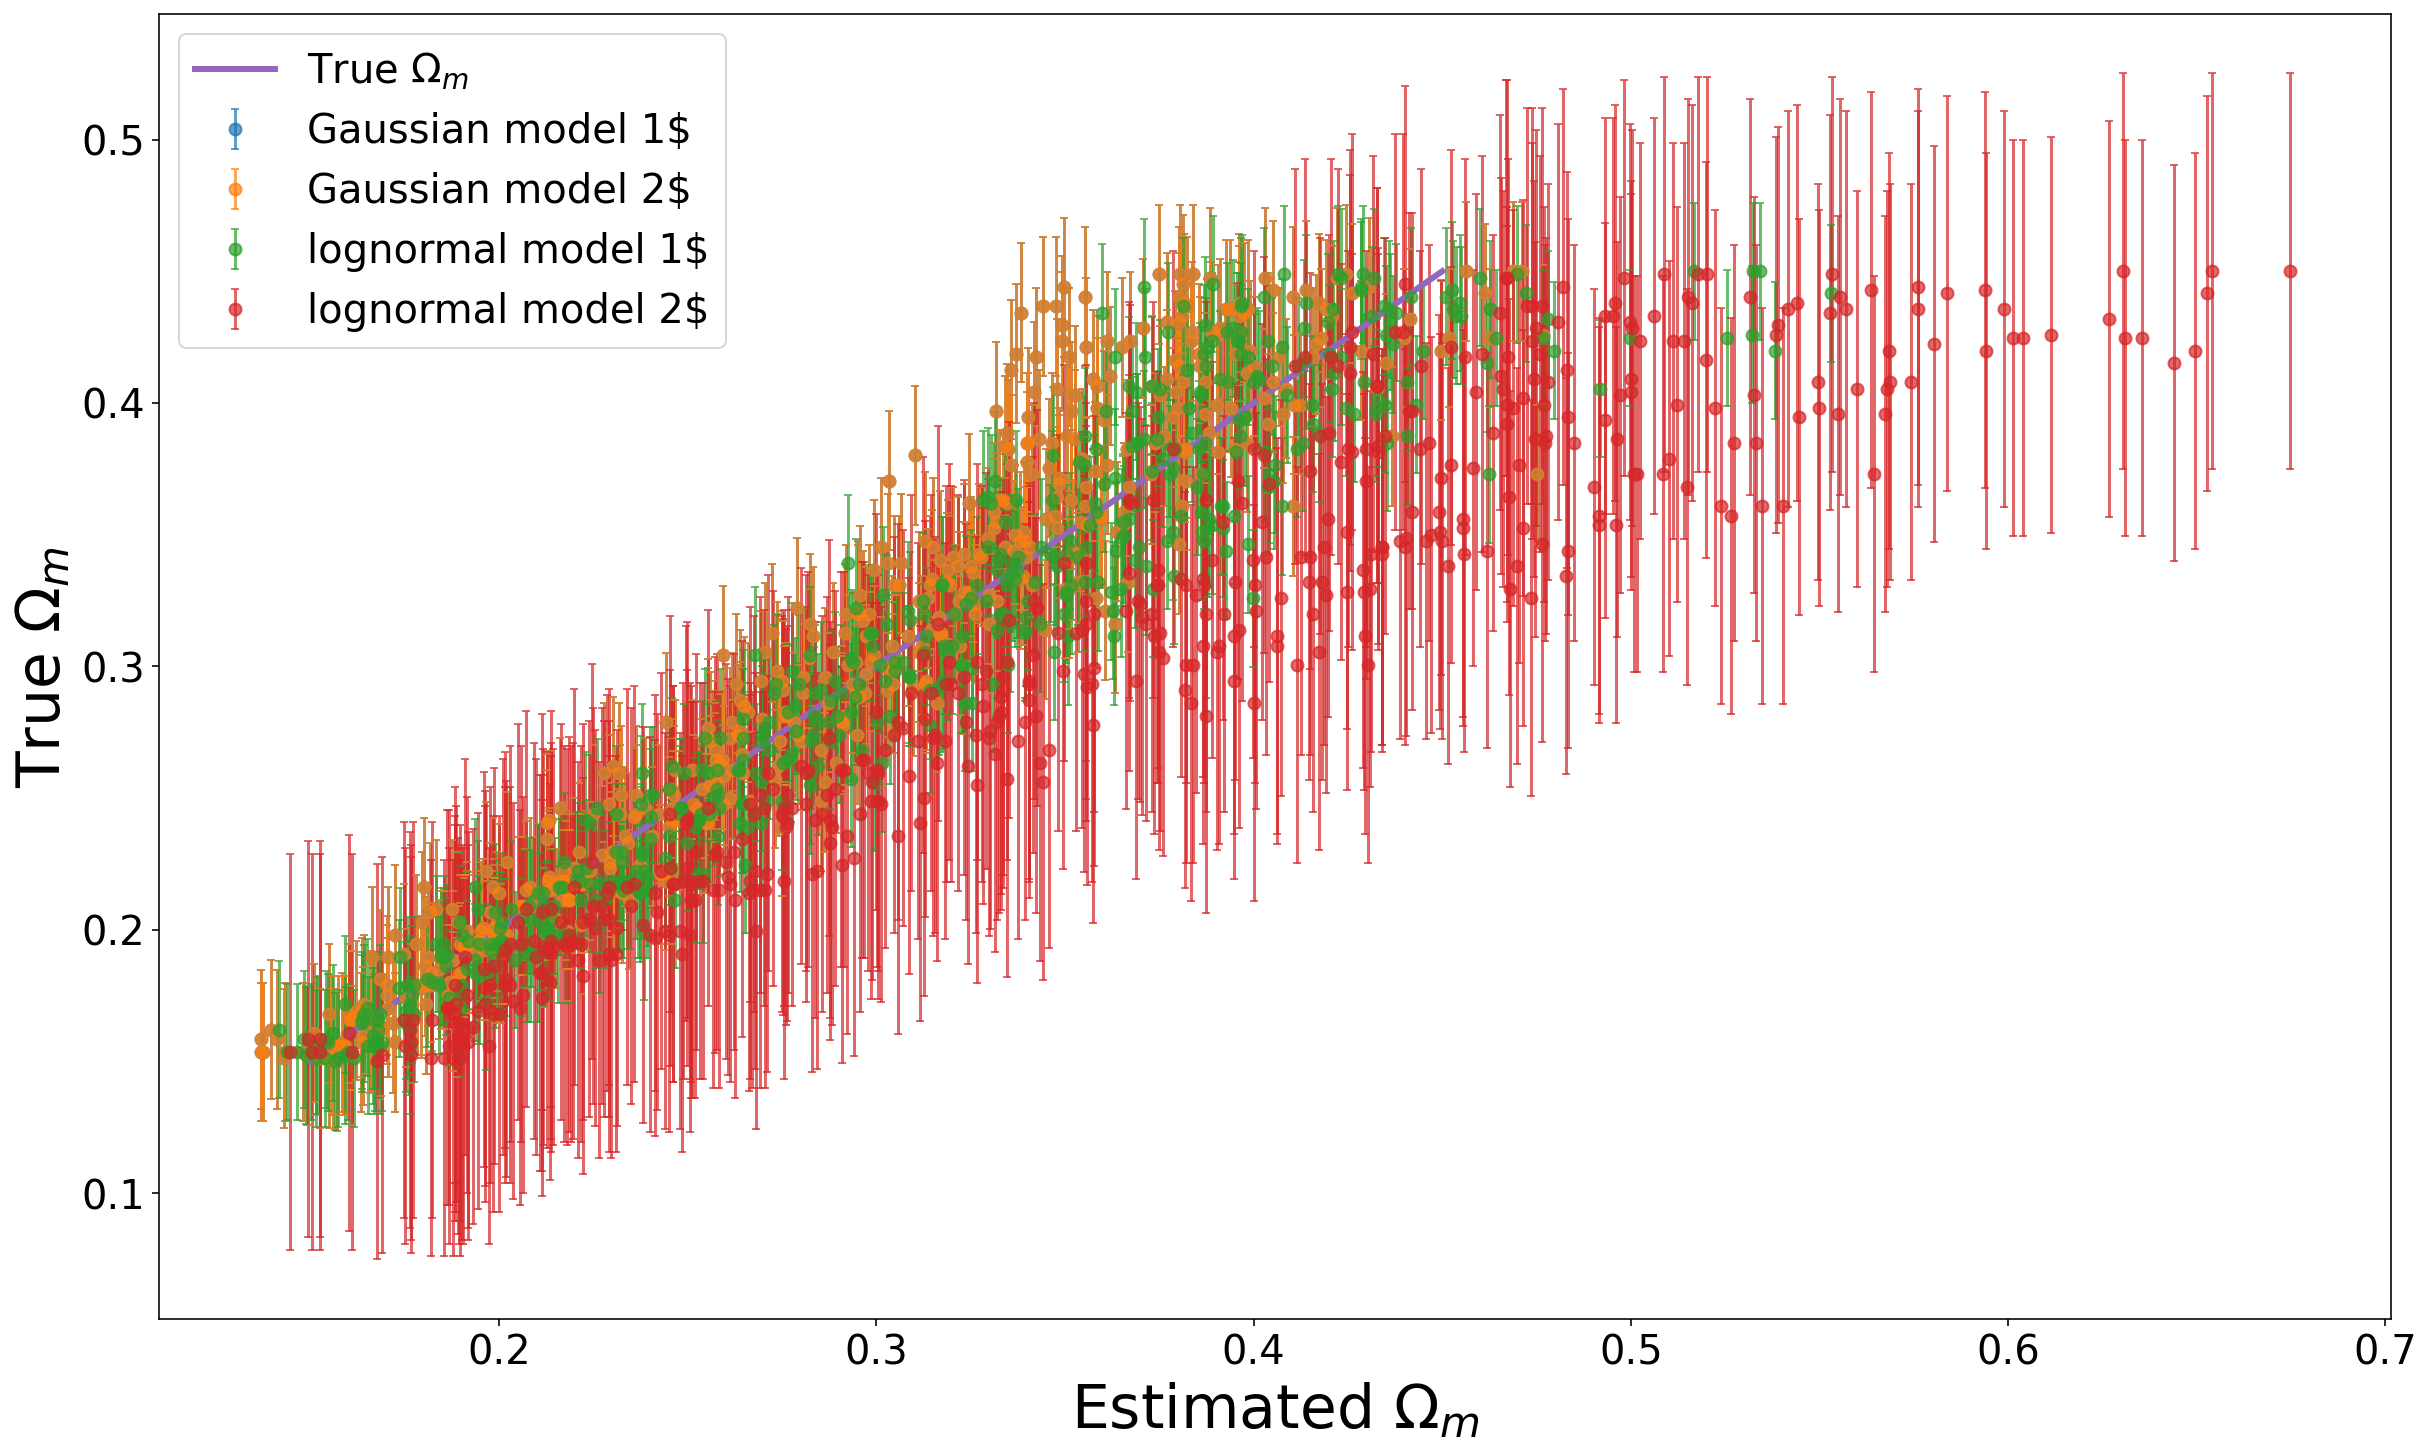

In [29]:
plt.figure(figsize=(20,12))
plt.errorbar(prediction_val_Gauss_1[::step_size, 0],labels_val_Gauss[::step_size, 0], np.sqrt(Omega_M_MSE_Gauss_1), label=f'Gaussian model 1$', fmt='o',capsize=2, alpha=0.7)
plt.errorbar(prediction_val_Gauss_1[::step_size, 0],labels_val_Gauss[::step_size, 0], np.sqrt(Omega_M_MSE_Gauss_1), label=f'Gaussian model 2$', fmt='o',capsize=2, alpha=0.7)
plt.errorbar(prediction_val_lognormal_1[::step_size, 0],labels_val_lognormal[::step_size, 0], np.sqrt(Omega_M_MSE_lognormal_1), label=f'lognormal model 1$', fmt='o',capsize=2, alpha=0.7)
plt.errorbar(prediction_val_lognormal_2[::step_size, 0],labels_val_lognormal[::step_size, 0], np.sqrt(Omega_M_MSE_lognormal_2), label=f'lognormal model 2$', fmt='o',capsize=2, alpha=0.7)
plt.plot(Omega_M_x, Omega_M_x, label="True $\Omega_m$",linewidth=3)
plt.legend(fontsize=20)
plt.xlabel(f"Estimated $\Omega_m$", fontsize=30)
plt.ylabel(f"True $\Omega_m$", 
           fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v4/Errobar_Omega_M_2.png',bbox_inches='tight')
plt.show()

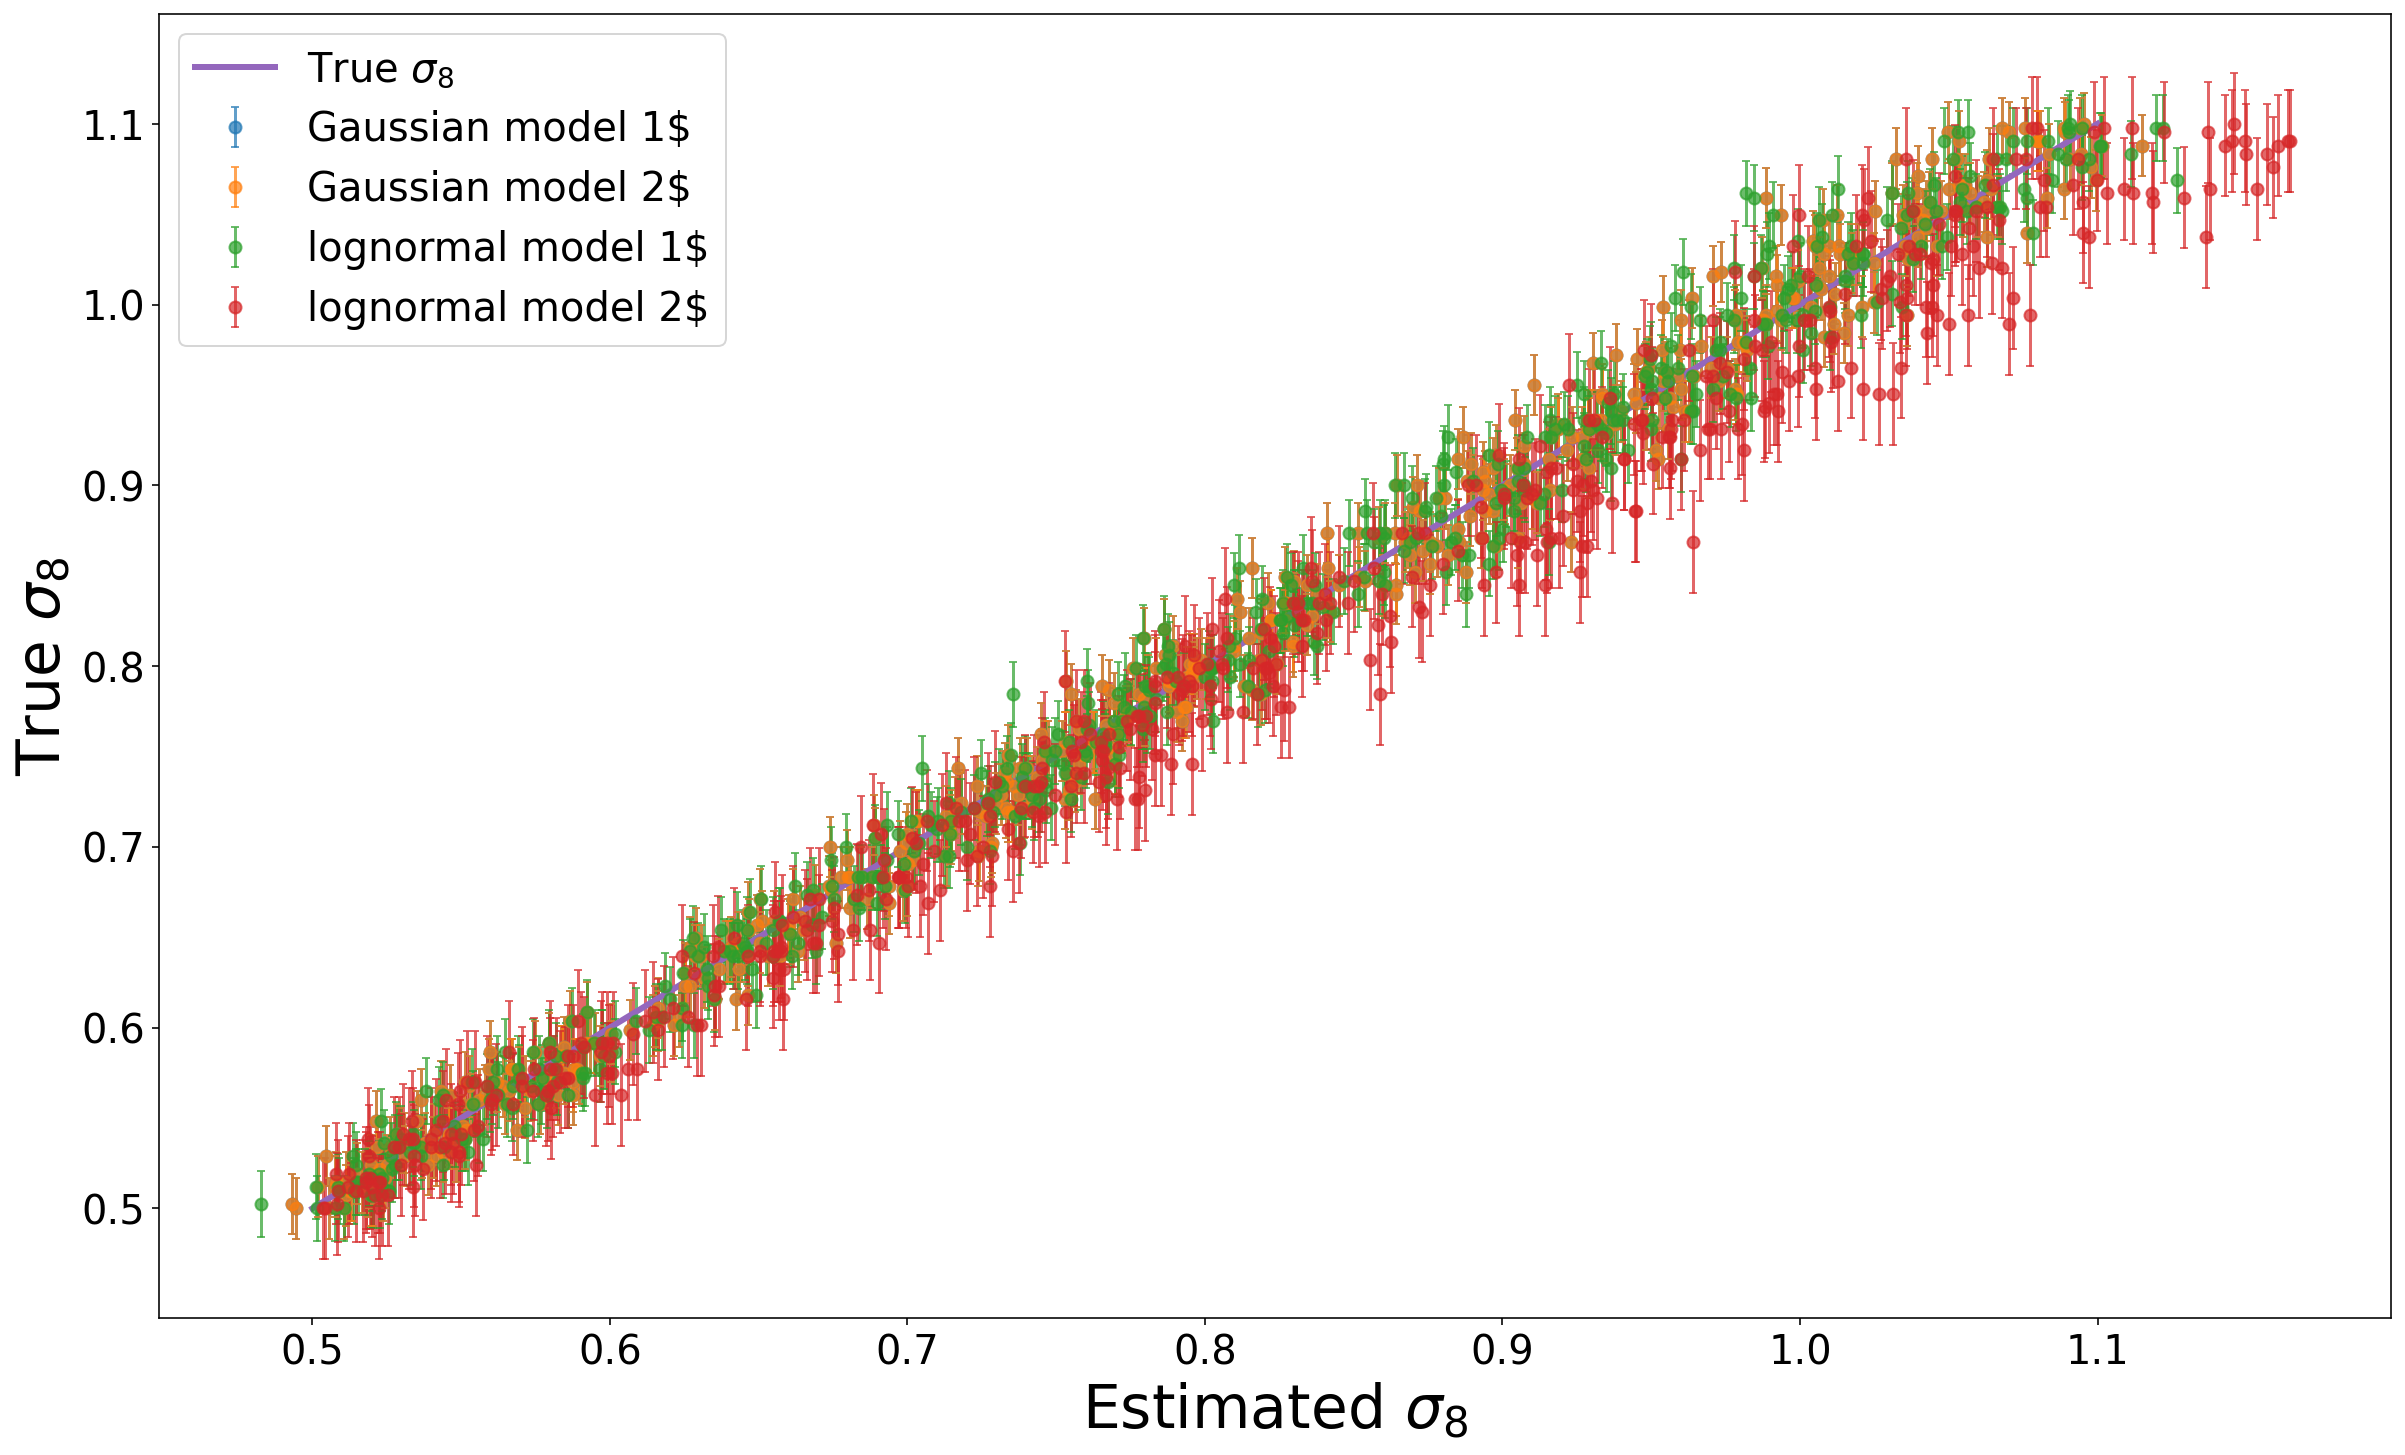

In [30]:
plt.figure(figsize=(20,12))
plt.errorbar(prediction_val_Gauss_1[::step_size, 1],labels_val_Gauss[::step_size, 1], np.sqrt(sigma_8_MSE_Gauss_1), label=f'Gaussian model 1$', fmt='o',capsize=2, alpha=0.7)
plt.errorbar(prediction_val_Gauss_1[::step_size, 1],labels_val_Gauss[::step_size, 1], np.sqrt(sigma_8_MSE_Gauss_1), label=f'Gaussian model 2$', fmt='o',capsize=2, alpha=0.7)
plt.errorbar(prediction_val_lognormal_1[::step_size, 1],labels_val_lognormal[::step_size, 1], np.sqrt(sigma_8_MSE_lognormal_1), label=f'lognormal model 1$', fmt='o',capsize=2, alpha=0.7)
plt.errorbar(prediction_val_lognormal_2[::step_size, 1],labels_val_lognormal[::step_size, 1], np.sqrt(sigma_8_MSE_lognormal_2), label=f'lognormal model 2$', fmt='o',capsize=2, alpha=0.7)
plt.plot(sigma_8_x, sigma_8_x, label="True $\sigma_8$",linewidth=3)
plt.legend(fontsize=20)
plt.xlabel(f"Estimated $\sigma_8$", fontsize=30)
plt.ylabel(f"True $\sigma_8$", 
           fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v4/Errobar_sigma_8_2.png',bbox_inches='tight')
plt.show()

#### Plot without lognormal model 2, it looks better...
#### But I have to accept this bad result...